In [372]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from collections import Counter
import ast 
import seaborn as sns
from scipy.optimize import curve_fit
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import statsmodels.api as sm
from sympy import symbols, integrate, lambdify, diff
import scipy.integrate as spi
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import f_oneway, kruskal
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import statsmodels.api as sm

sns.set_palette("pastel")

Normalize df

In [373]:
def scale_csv_data(file_path, columns_to_scale):
    data = pd.read_csv(file_path)
    scaler = MinMaxScaler()

    def scale_column(column):
        lists = column.apply(ast.literal_eval)
        flattened = np.concatenate(lists.values)
        scaled_flattened = scaler.fit_transform(flattened.reshape(-1, 1)).flatten()
        scaled_lists = []
        start = 0
        for lst in lists:
            end = start + len(lst)
            scaled_lists.append(scaled_flattened[start:end].tolist())
            start = end
        return [str(lst) for lst in scaled_lists]
    
    for column in columns_to_scale:
        data[column] = scale_column(data[column])

    return data

### Histogram for Germination Frame Frequency

In [374]:
def germination_frequency(plots_folder: str, GERMINATION: list, output: int = 1) -> None:

  germination_frames_list = GERMINATION.apply(lambda x: x.index(1)) #list of germination frames as indices

  #print times frame germination occurs
  frame_counts = Counter(germination_frames_list)
  sorted_frame_counts = sorted(frame_counts.items())
  for frame_number, count in sorted_frame_counts:
      if output == 1:
        print(f"Frame: {frame_number}, Frequency: {count}")
      
  #histogram plot 
  bin_number = 12
  sns.histplot(germination_frames_list, bins = bin_number, label = f"{bin_number} bins")#, bins=25)
  plt.title("Germination Events")
  plt.xlabel("Hour")
  plt.ylabel("Spores Germination Frequency")
  plt.xlim([0, 287])
  plt.xticks([11, 35, 59, 83, 107, 131, 155, 179, 203, 227, 251, 275], [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23])
  plt.grid()
  plt.legend()
  plt.savefig(plots_folder + "germination_frequency.jpg")

  if output != 1:
    plt.close()
  return sorted_frame_counts

def germination_percentage(sorted_frame_counts):
    plt.clf()
    total_spores = sum(count for frame, count in sorted_frame_counts)
    spores_count = total_spores
    frames = [0]
    percents = [100]
    percent_plot = [100]
    frame_dict = dict(sorted_frame_counts)

    percent = 100  # Initialize percent outside the loop

    for frame_number in range(1, 289):
      if frame_number in frame_dict:
        count = frame_dict[frame_number]
        spores_count -= count
        percent = spores_count / total_spores * 100
        percent_plot.append(percent)
      percents.append(percent)
      frames.append(frame_number)

    sns.lineplot(x=frames, y=percents)
    plt.xlabel('Hour')
    plt.ylabel('Percentage')
    plt.title('Germination Percentage')
    plt.xticks([11, 35, 59, 83, 107, 131, 155, 179, 203, 227, 251, 275], [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23])
    plt.yticks([0, 25, 50, 75, 100])
    plt.grid()
    plt.show()
    print(f"Percentages: {percent_plot}")


### Descriptive Statistics

Group together spores and create a boxplot at each timestep for all spores

In [375]:
def group_by_germination(df, feature_str: list[str]):
  ''' 
  Takes in original data frame and list of features to analyze and group together
  returns grouped data
  '''
  data_stats = df.copy()

  for feature in feature_str:
    data_stats[feature] = data_stats[feature].apply(ast.literal_eval)

  data_stats['Germination Frame'] = data_stats['GERMINATION'].apply(lambda x: x.index(1)) #get germination frame where first "1" occurs 
  grouped_data = data_stats.groupby("Germination Frame")

  return grouped_data, data_stats

In [376]:
def get_min_max(df, feature: str) -> int:
    data_max = []
    data_min = []
    data = df[feature].apply(ast.literal_eval) 
    for row in data:
        data_max.append(max(row))
        data_min.append(min(row))
    return min(data_min), max(data_max)


def box_plot_statistics(germ_time, data, column: str, feature: str, y_minmax: [int, int], show_plot = 1):
    min_feature = y_minmax[0]
    max_feature = y_minmax[1]
    
    aligned_data = [pd.Series(data) for data in data[column]]
    aligned_df = pd.DataFrame(aligned_data)
    melted_aligned_df = aligned_df.melt(var_name='Frame', value_name=feature) #long format
    
    # plotting
    plt.figure(figsize=(4, 3))
    sns.boxplot(x='Frame', y=feature, data=melted_aligned_df)
    plt.axvline(x=germ_time, color='red', linestyle='--', label=f'Germination Frame {germ_time}')
    plt.title(f'{feature} Statistics for Spores Germinated at Frame {germ_time}')
    plt.xlabel('Frame')
    plt.xticks([0, 50, 100, 150, 200, 150, 200, 250])
    plt.ylabel(feature)
    plt.ylim([min_feature, max_feature])
    plt.legend()
    plt.savefig(f"{plots_folder}  {feature} _boxplot_ + {germ_time} .jpg")
    
    if show_plot != 1:
        plt.close()

### Spatial

In [377]:
def plot_xy_germinationframe(df, show_plot = 1):  
  '''
  plots x and y location with germination frame as z value 
  '''
  plt.figure(figsize=(6, 3))
  #plot
  scatter = plt.scatter(df['X_POSITION'], df['Y_POSITION'], c = df['Germination Frame'], cmap = 'gist_ncar', s=30)
  plt.colorbar(scatter, label='Germination Frame')
  plt.xlabel('X')
  plt.ylabel('Y')

  plt.gca().invert_yaxis()
  plt.title('Spores by Germination Frame')
  plt.grid(True)
  plt.savefig(f"{plots_folder}germinationframe_location.jpg")

  if show_plot != 1:
    plt.close()
  ###VALIDATE THIS overlay on tiff

### Signal Summation

In [378]:
def total_signal(df, INTENSITY, GERMINATION):
  '''
  sums all intensities until germination and plots frame as x value and total sum as y 
  '''
  germination_totalintensity = []

  df['Germination Frame'] = GERMINATION.apply(lambda x: x.index(1)) #get germination frame where first "1" occurs 

  for i in range(len(df)):
    spore_intensities = INTENSITY[i]
    spore_germination_frame = df.loc[i, "Germination Frame"] 
    intensities_before_germination = spore_intensities[0: spore_germination_frame]
    total_intensity = np.sum(intensities_before_germination)
    germination_totalintensity.append(np.array([spore_germination_frame, total_intensity]))

  germination_totalintensity_np = np.array(germination_totalintensity)

  plt.figure(figsize=(4, 3))
  plt.scatter(germination_totalintensity_np[:, 0], germination_totalintensity_np[:, 1])
  plt.xlabel("Germination Frame")
  plt.ylabel("Sum Intensity")
  plt.show()
  plt.close()

### Feature value before germination

### Scatter and Boxplots of feature for initial, last, and average value before germination

### Feature Analysis

In [379]:
def germinationframe_feature(df, FEATURE: list, GERMINATION: list):
  '''
  takes in a FEATURE and GERMINATION and returns avg feature, initial value of feature, and last value of feature (all before germination)
  '''
  avg_germination_feature = []
  initial_germination_feature = []
  last_germination_feature = []

  df['Germination Frame'] = GERMINATION.apply(lambda x: x.index(1)) #get germination frame where first "1" occurs 

  for i in range(len(df)):
    spore_feature = FEATURE[i]
    spore_germination_frame = df.loc[i, "Germination Frame"]
    feature_before_germination = spore_feature[0: spore_germination_frame]


    avg_feature = np.mean(feature_before_germination)
    initial_feature = np.mean(feature_before_germination[0: 11]) #averaged over first and last frames
    last_feature = np.mean(feature_before_germination[-5: -1])

    avg_germination_feature.append(np.array([spore_germination_frame, avg_feature]))
    initial_germination_feature.append(np.array([spore_germination_frame, initial_feature]))
    last_germination_feature.append(np.array([spore_germination_frame, last_feature]))

  return [np.array(avg_germination_feature), np.array(initial_germination_feature), np.array(last_germination_feature)]
####--------


def subplot_scatter(arrays, y_label, subplot_title, min_max, framerange, show_plots = 1):
    avg_array, initial_array, last_array = arrays


    # difference between initial value and last value before germination 
    diff_array = avg_array.copy()
    diff_array[:, 1] = last_array[:, 1] - initial_array[:, 1]
    if show_plots == 1:
        fig, axs = plt.subplots(2, 4, figsize=(16, 8))


        # color palette
        subplot_ylabels = [f"Average {y_label}", f"Initial {y_label}", f"Last {y_label}", f"Difference in {y_label}"]
        palette = sns.color_palette("pastel", 5)

        # group germination frames for box plot
        group_frames = framerange # HARDCODED


        # scatter plots
        for i, array in enumerate([avg_array, initial_array, last_array, diff_array]):
            for j, frames in enumerate(group_frames):
                group_indices = [frame_index for frame_index, germination_frame in enumerate(array[:, 0]) if germination_frame in range(frames[0], frames[1])]
                axs[0, i].scatter(array[group_indices, 0], array[group_indices, 1], color=palette[j], label=f'Frames {frames[0]} - {frames[-1]}')
            axs[0, i].set_title(subplot_ylabels[i])
            axs[0, i].set_ylabel(f"{subplot_title} before Germination")
            axs[0, i].set_ylim(min_max)
            axs[1, i].set_ylim(min_max)
            axs[0, i].legend()

        # y axis limits for difference plot 
        axs[0, 3].set_ylim([min(diff_array[:, 1]), max(diff_array[:, 1])])
        axs[1, 3].set_ylim([min(diff_array[:, 1]), max(diff_array[:, 1])])

        # box plots by frame groups
        arrays = [avg_array, initial_array, last_array, diff_array]

        for array_index, array in enumerate(arrays):
            df_list = []
            for frame_index, frames in enumerate(group_frames):

                spore_values = [array[row_index, 1] for row_index, row in enumerate(array) if array[row_index, 0] in range(frames[0],frames[1])]
                df_list.append(pd.DataFrame({f'{frames[0]} - {frames[-1]}': spore_values}))

            boxplot_data = pd.concat(df_list, axis=1)
            sns.boxplot(data=boxplot_data, ax=axs[1, array_index], palette=palette, width=0.5)

        plt.tight_layout()
        plt.show()

    return diff_array
    #heat map between initial and difference 
    

### Fraction of two features

In [380]:
def intensity_area_ratio(df, INTENSITY, AREA):
  '''
  get intensity over all frames divided by area
  return df of ratios
  '''
  
  if isinstance(AREA, pd.Series):
    INTENSITY = INTENSITY.to_list()
    AREA = AREA.to_list()
    
  if isinstance(AREA, pd.DataFrame):
    AREA = AREA.values.tolist()

  
  RATIOS = []
  for spore_index in range(len(INTENSITY)):
    spore_intensity = INTENSITY[spore_index]
    spore_area = AREA[spore_index]

    # if passing pd.dataframe insteaed of series
    if len(spore_area) == 1:
      spore_area = spore_area[0]

    spore_ratios = []
    for frame_index in range(len(INTENSITY[spore_index])):
      ratio = spore_intensity[frame_index]/spore_area[frame_index]
      spore_ratios.append(ratio)
    RATIOS.append(spore_ratios)  
  return pd.DataFrame(RATIOS)

### Fitting a Linear Model to each spore

In [381]:
def polynomial_model(x, *coefficients):
    summ = 0
    for index, coefficient in enumerate(coefficients):
        summ += coefficient * x ** index
    return summ

def fit_polynomial_model(df, INTENSITY, GERMINATION, yaxis, degree, show_plots=1):
    df['Germination Frame'] = GERMINATION.apply(lambda x: x.index(1))
    INTENSITY_LIST = INTENSITY.to_list()

    df["INTEGRAL"] = None
    df["DERIVATIVE"] = None

    grouped = df.groupby('Germination Frame')
    for germination_frame, group in grouped:
        fig, axs = plt.subplots(1, 3, figsize=(12, 3))  
        sns.set_palette("pastel")

        for spore_index in group.index:
            intensities = INTENSITY_LIST[spore_index]
            frames = list(range(len(intensities)))

            frames_until_germination = list(range(germination_frame + 1))
            intensity_until_germination = intensities[:germination_frame + 1]

            # fitting
            initial_guess = [1] * (degree + 1)
            polynomial_lambda = lambda x, *params: polynomial_model(x, *params)
            parameters_allframes, _ = curve_fit(polynomial_lambda, frames, intensities, p0=initial_guess)

            polynomial_lambda_until_germination = lambda x, *params: polynomial_model(x, *params)
            parameters_untilgermination, _ = curve_fit(polynomial_lambda_until_germination, frames_until_germination, intensity_until_germination, p0=initial_guess)

            fitted_line_values = np.array([frames, polynomial_model(np.array(frames), *parameters_allframes)])
            fitted_line_values_until_germination = np.array([frames_until_germination, polynomial_model(np.array(frames_until_germination), *parameters_untilgermination)])

            #get derivative up to and including germinaiton frame
            derivatives = []
            integrals = []
            for frame in frames_until_germination:
                derivative_fcn = derivative_function(parameters_untilgermination)
                derivative_at_frame = derivative_fcn(frame)
                derivatives.append(derivative_at_frame)
            df.loc[spore_index, "DERIVATIVE"] = str(derivatives)

            #integral up to germination frame
            for frame in frames_until_germination[0: -1]:
                integral_fcn = integral_function(parameters_untilgermination)
                integral_at_frame = integral_fcn(frame) - integral_fcn(0)#? 
                integrals.append(integral_at_frame)       
            df.loc[spore_index, "INTEGRAL"] = str(integrals)         
            
            # plotting fitted line 
            sns.lineplot(ax = axs[0], x=frames, y=intensities, color="lightgrey")#, label="Data", linewidth=1)
            #sns.lineplot(x=fitted_line_values[0, :], y=fitted_line_values[1, :], label='Fitted to all data')
            sns.lineplot(ax = axs[0], x=fitted_line_values_until_germination[0, :], y=fitted_line_values_until_germination[1, :])#, label='Fitted until germination frame + 1')
            axs[0].axvline(germination_frame, color="black", linestyle="--")#, label="Germination")
            
            #plotting derivative
            sns.lineplot(ax = axs[1], x = frames_until_germination, y = derivatives)
            axs[1].axvline(germination_frame, color="black", linestyle="--")#, label="Germination")

            #plotting integral
            sns.lineplot(ax = axs[2], x = frames_until_germination[0: -1], y = integrals)


        axs[0].set_xlabel('Frames')
        axs[0].set_ylabel('Intensity')
        axs[0].set_ylim(yaxis)
        axs[0].set_title(f'Fitted Polynomials for GF {germination_frame}')
        
        axs[1].set_xlabel('Frames')
        axs[1].set_xlim([0, len(INTENSITY[0])])
        axs[1].set_ylabel("Intensity Derivative")
        axs[1].set_ylim([-5, 25])
        axs[1].set_title(f'Derivatives for GF {germination_frame}')

        axs[2].set_xlim([0, len(INTENSITY[0])]) 
        axs[2].set_ylim([0, 3000])
        axs[2].set_title(f'Integrals for GF {germination_frame}')
        plt.tight_layout()

    if show_plots != 1:
        plt.close()
    if show_plots == 1:
        plt.show()

    return df

def integral_function(parameters):
    # polynomial expression as symbolic variable
    x = symbols('x')
    polynomial_expr = sum(p * x**i for i, p in enumerate(parameters))

    # integrate
    integral_expr = integrate(polynomial_expr, x)

    # integral in [0, germintaion_frame]
    integral_func = lambdify(x, integral_expr, 'numpy')
    return integral_func

def derivative_function(parameters):
    x = symbols("x")
    polynomial_expr = sum(p * x**i for i, p in enumerate(parameters))
    derivative_expr = diff(polynomial_expr, x)
    derivative_func = lambdify(x, derivative_expr, 'numpy')
    return derivative_func

### Heatmap

In [382]:
def heatmap(df, arrays, DIFF, feature, show_plots = 1):
    AVG, INITIAL, LAST = arrays
    germination_frames = list(AVG[:, 0])
    avg = list(AVG[:, 1])
    initial = list(INITIAL[:, 1])
    last = list(LAST[:, 1])
    diff = list(DIFF[:, 1])
    
    df = pd.DataFrame({
        "Germination Frame": germination_frames,
        f"Average": avg,
        f"Initial": initial, 
        f"Last": last,
        f"Difference": diff
    })

    correlation = df.corr()
    
    # plot heatmap
    plt.figure(figsize=(5, 3))
    sns.heatmap(correlation, annot=True, vmin=-1, vmax=1)
    plt.title(f"{feature} Correlation before Germination")
    if show_plots == 1:
        plt.show()

    if show_plots != 1:
        plt.close()
    plt.clf()

Pearson Correaltion Coefficient: 

In [383]:
def plain_heatmap(df, features_list, plot_title):
  '''takes in df in format where each row denotes a spore and each column is a feature and each cell is feature over time in a list'''
  plt.clf()

  correlation_matrices = []

  for spore_index in range(len(df)):
    spore_features = []
    for feature in features_list:
      spore_feature = ast.literal_eval(df.loc[spore_index, feature])
      spore_features.append(spore_feature)
    spore_df = pd.DataFrame(spore_features).T
    spore_df.columns = features_list

    spore_feature_correlation = spore_df.corr()
    #heatmap for individual spore: 
    #sns.heatmap(spore_feature_correlation, annot = True, vmin = 0, vmax = 1, cmap = "coolwarm")
    
    #heatmap for all spores: 
    correlation_matrices.append(spore_feature_correlation)
  
  avg_correlation_matrix = np.mean(correlation_matrices, axis=0)
  avg_correlation_df = pd.DataFrame(avg_correlation_matrix, index=features_list, columns=features_list)

  # Plot the heatmap for the average correlation matrix
  plt.figure(figsize=(8, 6))
  sns.clustermap(avg_correlation_df, annot=True, vmin=0, vmax=1, cmap="coolwarm")
  plt.title(plot_title)
  plt.show()

In [384]:
def initial_value_heatmap(df, features_list, plot_title):
  correlation_matrix = df.corr()
  plt.figure(figsize=(8, 6))
  sns.clustermap(correlation_matrix, annot=True, vmin=-1, vmax=1, cmap="coolwarm")
  plt.title(plot_title)
  plt.show()

Turkey Analysis Function: 

In [385]:
def tukey_analysis(df, feature: list[str], frameranges: list[tuple]):
        #feature_index = df.columns.get_loc(feature)
        print(f"doing ANOVA and tukey analysis for {feature}...")
        dataframe_rows = []
        frame_groups = []
        for group_index in range(len(frameranges)):
            frame_groups.append([])

        for group_i, framerange in enumerate(frameranges):
            for spore_index in range(len(df)):
                spore_info = df.loc[spore_index, feature]
                spore_germ = df.loc[spore_index, "GERMINATION"]
                if spore_germ in range(framerange[0], framerange[1]):
                    frame_groups[group_i].append(spore_info)
                    dataframe_rows.append([spore_info, str(framerange)])
        anova_result = f_oneway(*frame_groups)
        print(f"ANOVA one-way results for {feature}:")
        print(f"{anova_result}")
        
        df = pd.DataFrame(dataframe_rows, columns = [feature, "Frame_Group"])
        tukey = pairwise_tukeyhsd(endog=df[feature],
                          groups=df["Frame_Group"],
                          alpha=0.05)
        print(f"Tukey Analysis:")
        print(tukey)


### Summed Intensity

In [386]:
def sum_intensity(GERMINATION, INTENSITY, time_between_frames):
  summed_intensity_allspores = []
  for spore_index, spore_row in enumerate(INTENSITY):
    germination_frame = GERMINATION.apply(lambda x: x.index(1))
    summed_intensity: int = 0 
    summed_intensities: list[int] = []
    for intensity_index, intensity_value in enumerate(spore_row[0: int(germination_frame[spore_index])]):
      summed_intensity += intensity_value * time_between_frames
      summed_intensities.append(summed_intensity)
    summed_intensity_allspores.append(summed_intensities)
  
  sum_intensity_df = pd.DataFrame(summed_intensity_allspores)
  
  for row_index in range(len(sum_intensity_df)):
    row = list(sum_intensity_df.iloc[row_index, :])
    xs = range(len(row))
    sns.lineplot(x = xs, y = row)


### Plot Features

In [387]:
def plot_feature_germ_frames(GERMINATION, FEATURE, feature: str):
    unique_germination_frames = GERMINATION.apply(lambda x: x.index(1)).unique()
    
    # Create a plot for each unique germination frame
    for germination_frame in unique_germination_frames:
        plt.figure()
        plt.title(f"Germination Frame: {germination_frame}")
        for spore_index, spore_row in enumerate(FEATURE):
            if GERMINATION.iloc[spore_index].index(1) == germination_frame:
                sns.lineplot(x = range(len(spore_row)), y = spore_row)# color=color_map[germination_frame], linewidth=0.5)
        plt.axvline(x = germination_frame, color = "lightgrey", linestyle = '--', label = "Germination")
        plt.xlabel("Frame")
        plt.ylabel(feature)
        plt.show()

In [388]:
def plot_feature_example(GERMINATION, FEATURE, feature: str, frames: list[int]):
    plt.clf()
    sns.color_palette(palette='Spectral')

    for frame in frames[0:5]:
      plt.axvline(x = frame - 1, color='lightgrey', linestyle='--') 
    for frame in frames[:: -1]: 
      tmp = 0
      for spore_index, feature_row in enumerate(FEATURE):
        germination_frame = GERMINATION.iloc[spore_index].index(1)
        if germination_frame == frame:
          tmp += 1
          if tmp == 1:
            sns.lineplot(x=range(germination_frame), y=feature_row[:germination_frame], label=f'Germinated at L-alanine Exposure {frames.index(frame) + 1}', linewidth=4)
            break  
          
    #legend upside down no more !
    handles, labels = plt.gca().get_legend_handles_labels()
    handles = handles[::-1]
    labels = labels[::-1]

    plt.legend(handles, labels, loc='upper right')
    plt.title(f"Sample Behavior for {feature} over Time")
    plt.xlabel('Frame')
    plt.ylabel(feature)
    plt.xlim(0, 95)
    plt.ylim(0, 1)
    plt.savefig(f"{plots_folder + feature}_sample.jpg")
    plt.show()

### Main 

In [389]:
def Main(df, plots_folder, time_between_frames, combined_df = 0):
  print(f"data has columns {list(df.columns)}...")
  print(f"analyzing {len(df)} spores...")


  framerange = [(0, 25), (25, 50), (50, 75), (75, 100), (100, 300)]
  # turning model data into lists
  INTENSITY: list[list] = df["INTENSITY"].apply(ast.literal_eval) 

  AREA: list[list] = df["AREA"].apply(ast.literal_eval)
  GERMINATION: list[list] = df["GERMINATION"].apply(ast.literal_eval)
  ELLIPSE_MINOR: list[list] = df["ELLIPSE MINOR"].apply(ast.literal_eval)
  ELLIPSE_MAJOR: list[list] = df["ELLIPSE MAJOR"].apply(ast.literal_eval)
  PERIMETER: list[list] = df["PERIMETER"].apply(ast.literal_eval)
  CIRCULARITY: list[int] = df["CIRCULARITY"].apply(ast.literal_eval)
  GERMINANT_EXPOSURE: list[int] = df["GERMINANT EXPOSURE"].apply(ast.literal_eval)
  ELLIPSE_RATIO: list[int] = df["ELLIPSE ASPECT RATIO"].apply(ast.literal_eval)


  # germination frequency 
  frame_counts = germination_frequency(plots_folder, GERMINATION, 1)
  germination_percentage(frame_counts)

  # group data by germination frame
  groups, data_stats = group_by_germination(df, ["INTENSITY", "AREA", "GERMINATION"])

  # used for plot limits 
  min_intensity, max_intensity = get_min_max(df, "INTENSITY")
  min_area, max_area = get_min_max(df, "AREA")
  min_ellipse_minor, max_ellipse_minor = get_min_max(df, "ELLIPSE MINOR")
  min_ellipse_major, max_ellipse_major = get_min_max(df, "ELLIPSE MAJOR")
  min_perimeter, max_perimeter = get_min_max(df, "PERIMETER")
  min_circularity, max_circularity = get_min_max(df, "CIRCULARITY")
  min_ellipse, max_ellipse = get_min_max(df, "ELLIPSE ASPECT RATIO")


  #plot x, y, and germination frame  
  if combined_df == 0:
    plot_xy_germinationframe(data_stats)  


  #---------------------feature boxplots 

  #intensity
  intensity_arrays = germinationframe_feature(df, INTENSITY, GERMINATION)
  diff_intensity = subplot_scatter(intensity_arrays, "Intensity", "Intensity", [min_intensity, max_intensity], framerange)

  #plot measure of area 
  area_arrays = germinationframe_feature(df, AREA, GERMINATION) 
  diff_area = subplot_scatter(area_arrays, "Area", "Area", [min_area, max_area], framerange)

  # plot measure of ellipse minors 
  minor_arrays = germinationframe_feature(df, ELLIPSE_MINOR, GERMINATION)
  diff_minor = subplot_scatter(minor_arrays, "Ellipse Minor", "Ellipse Minor", [min_ellipse_minor, max_ellipse_minor], framerange)

  # plot measure of ellipse majors
  major_arrays = germinationframe_feature(df, ELLIPSE_MAJOR, GERMINATION)
  diff_minor = subplot_scatter(minor_arrays, "Ellipse Major", "Ellipse Major", [min_ellipse_major, max_ellipse_major], framerange, 0)

  #ellipse aspect
  ellipse_arrays = germinationframe_feature(df, ELLIPSE_RATIO, GERMINATION)
  diff_ellipseratio = subplot_scatter(ellipse_arrays, "Ellipse Aspect Ratio", "Ellipse Aspect Ratio", [min_ellipse, max_ellipse], framerange, 0)

  #perimeter
  perimeter_arrays = germinationframe_feature(df, PERIMETER, GERMINATION)
  diff_perim = subplot_scatter(perimeter_arrays, "Perimeter", "Perimeter", [min_perimeter, max_perimeter], framerange, 0)

  #circularity
  circularity_arrays = germinationframe_feature(df, CIRCULARITY, GERMINATION)
  diff_circularity = subplot_scatter(circularity_arrays, "Circularity", "Circularity", [min_circularity, max_circularity], framerange, 0)

  #--------------------------- FITTED POLYNOMIAL
  #df_integrals = fit_polynomial_model(df, INTENSITY, GERMINATION, [min_intensity, max_intensity], 7, show_plots = 0)
  #INTEGRAL: list[list] = df["INTEGRAL"].apply(ast.literal_eval) # fix this? 
  #DERIVATIVE : list[list] = df["DERIVATIVE"].apply(ast.literal_eval)
  '''
  Columns: 
       ['Unnamed: 0', 'INTENSITY', 'AREA', 'GERMINANT EXPOSURE', 'GERMINATION',
       'ELLIPSE MINOR', 'ELLIPSE MAJOR', 'PERIMETER', 'CIRCULARITY',
       'FRAME LIST', 'X_POSITION', 'Y_POSITION', 'Germination Frame',
       'INTEGRAL', 'DERIVATIVE']
  '''

  #heatmap between average correlations between features over all time
  plain_heatmap(df, ["GERMINATION", "INTENSITY", "AREA", "ELLIPSE MINOR", "ELLIPSE MAJOR", "PERIMETER", "CIRCULARITY", "GERMINANT EXPOSURE", "ELLIPSE ASPECT RATIO"], "Feature Correlations over Time")
  

  #heatmap between initial feature values and germination frames
  features_columns = ["GERMINATION", "INTENSITY", "AREA", "ELLIPSE MINOR", "ELLIPSE MAJOR", "PERIMETER", "CIRCULARITY", "ELLIPSE ASPECT RATIO"]

  germination_array = intensity_arrays[1][:, 0]
  df_initial_features = pd.DataFrame({
    'GERMINATION': germination_array, 
    "INTENSITY": intensity_arrays[1][:, 1],
    "AREA": area_arrays[1][:, 1],
    "ELLIPSE_MINOR": minor_arrays[1][:, 1],
    "ELLIPSE_MAJOR": major_arrays[1][:, 1],
    "PERIMETER":perimeter_arrays[1][:, 1],
    "CIRCULARITY":circularity_arrays[1][:, 1],
    "ELLIPSE_ASPECT_RATIO": ellipse_arrays[1][:, 1]
  })
  initial_value_heatmap(df_initial_features, features_columns, "Initial Feature Correlations")
  
  for feature in df_initial_features.columns.tolist():
    tukey_analysis(df_initial_features, feature, framerange)
  
  df_last_features = pd.DataFrame({
  'GERMINATION': germination_array, 
  "INTENSITY": intensity_arrays[2][:, 1],
  "AREA": area_arrays[2][:, 1],
  "ELLIPSE_MINOR": minor_arrays[2][:, 1],
  "ELLIPSE_MAJOR": major_arrays[2][:, 1],
  "PERIMETER":perimeter_arrays[2][:, 1],
  "CIRCULARITY":circularity_arrays[2][:, 1],
  "ELLIPSE_ASPECT_RATIO": ellipse_arrays[2][:, 1]
  })

  #heatmap between last feature values and germination frames
  initial_value_heatmap(df_last_features, features_columns, "Last Value of Feature before Germination Correlations")
  
  #sum intensity
  sum_intensity(GERMINATION, INTENSITY, time_between_frames)

  #plot features grouped by germination frame 
  #plot_feature_germ_frames(GERMINATION, INTENSITY, "Intensity")

  #plot one from each frame
  plot_feature_example(GERMINATION, INTENSITY, "Intensity", [14, 38, 62, 86])
  plot_feature_example(GERMINATION, AREA, "Intensity", [14, 38, 62, 86])
  plot_feature_example(GERMINATION, ELLIPSE_MINOR, "Ellipse Minor", [14, 38, 62, 86])
  plot_feature_example(GERMINATION, ELLIPSE_MAJOR, "Ellipse Major", [14, 38, 62, 86])
  plot_feature_example(GERMINATION, PERIMETER, "Perimeter", [14, 38, 62, 86])
  plot_feature_example(GERMINATION, CIRCULARITY, "Circularity", [14, 38, 62, 86])
  plot_feature_example(GERMINATION, ELLIPSE_RATIO, "Ellipse Aspect Ratio", [14, 38, 62, 86])

### M4581_s1 Analysis

data has columns ['Unnamed: 0', 'INTENSITY', 'AREA', 'GERMINANT EXPOSURE', 'GERMINATION', 'ELLIPSE MINOR', 'ELLIPSE MAJOR', 'PERIMETER', 'CIRCULARITY', 'FRAME LIST', 'ELLIPSE ASPECT RATIO', 'X_POSITION', 'Y_POSITION']...
analyzing 54 spores...
Frame: 13, Frequency: 1
Frame: 14, Frequency: 4
Frame: 37, Frequency: 5
Frame: 38, Frequency: 20
Frame: 39, Frequency: 1
Frame: 61, Frequency: 3
Frame: 62, Frequency: 12
Frame: 63, Frequency: 2
Frame: 64, Frequency: 1
Frame: 86, Frequency: 4
Frame: 182, Frequency: 1


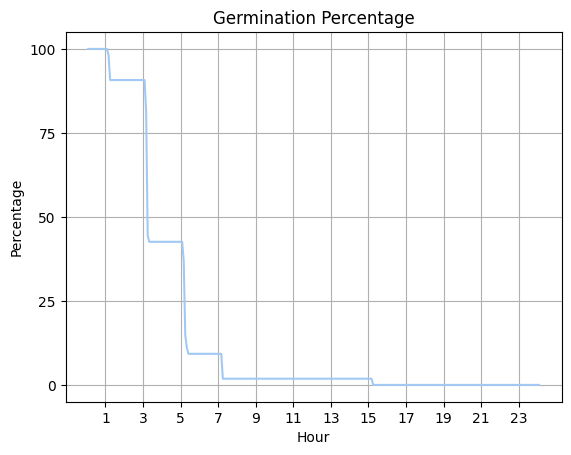

Percentages: [100, 98.14814814814815, 90.74074074074075, 81.48148148148148, 44.44444444444444, 42.592592592592595, 37.03703703703704, 14.814814814814813, 11.11111111111111, 9.25925925925926, 1.8518518518518516, 0.0]


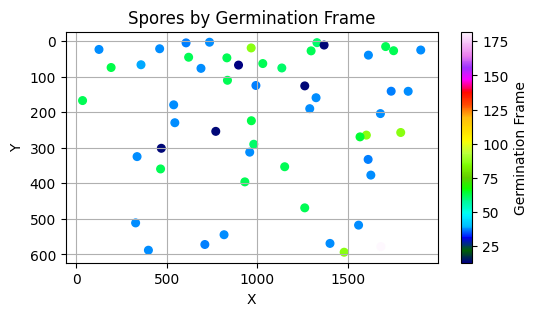

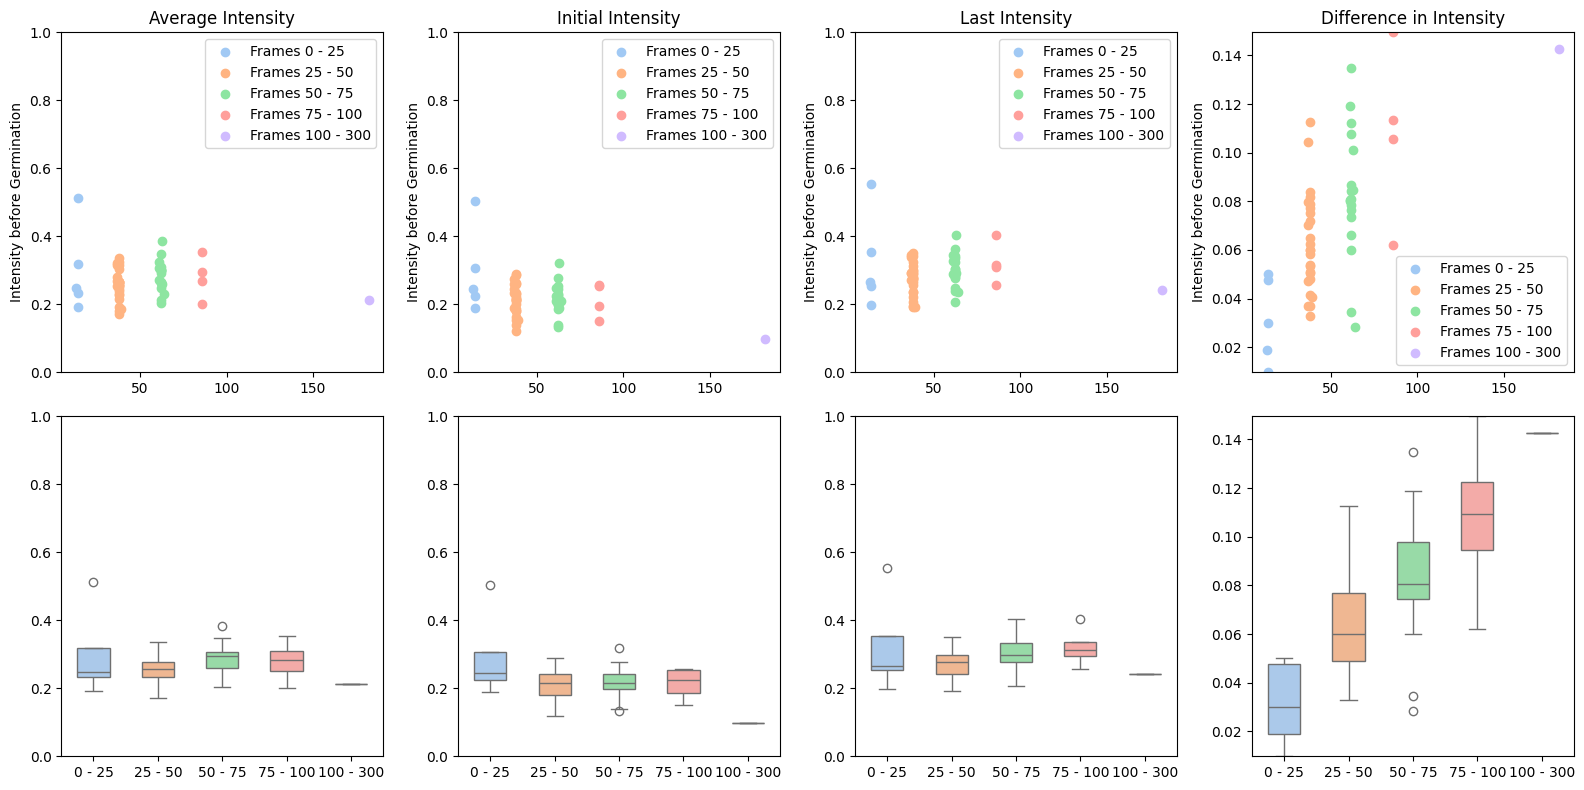

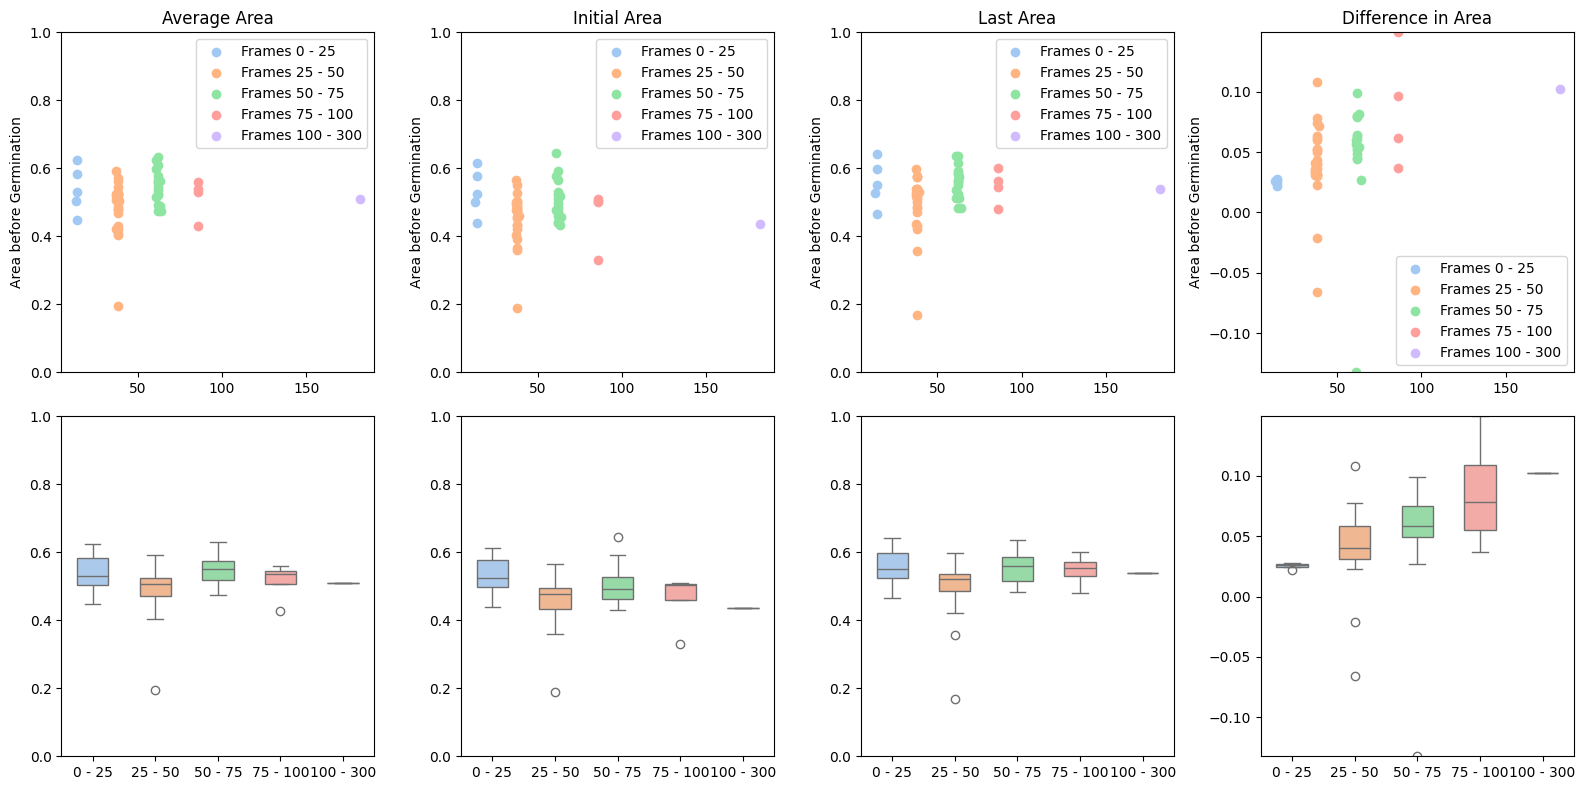

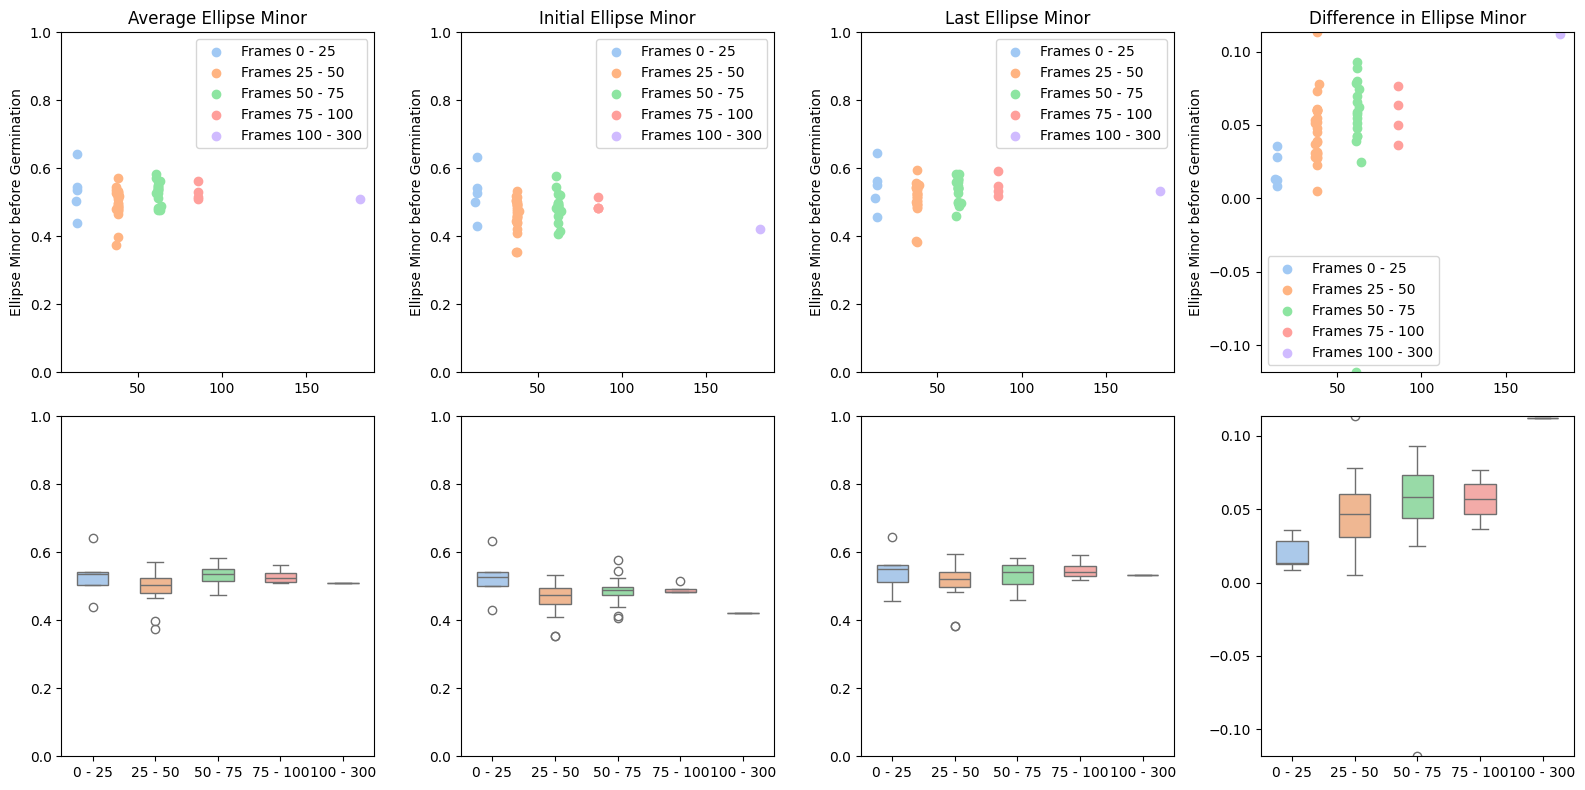

<Figure size 640x480 with 0 Axes>

<Figure size 800x600 with 0 Axes>

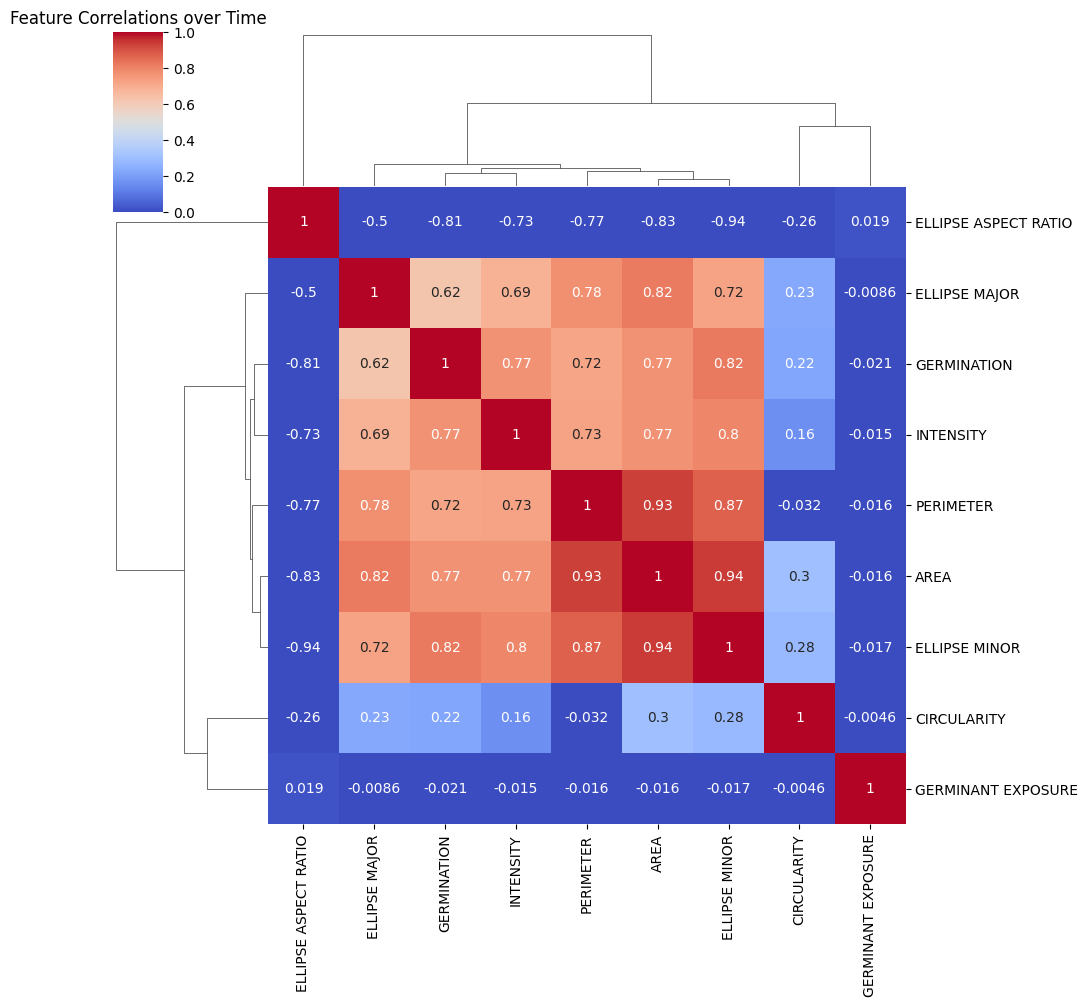

<Figure size 800x600 with 0 Axes>

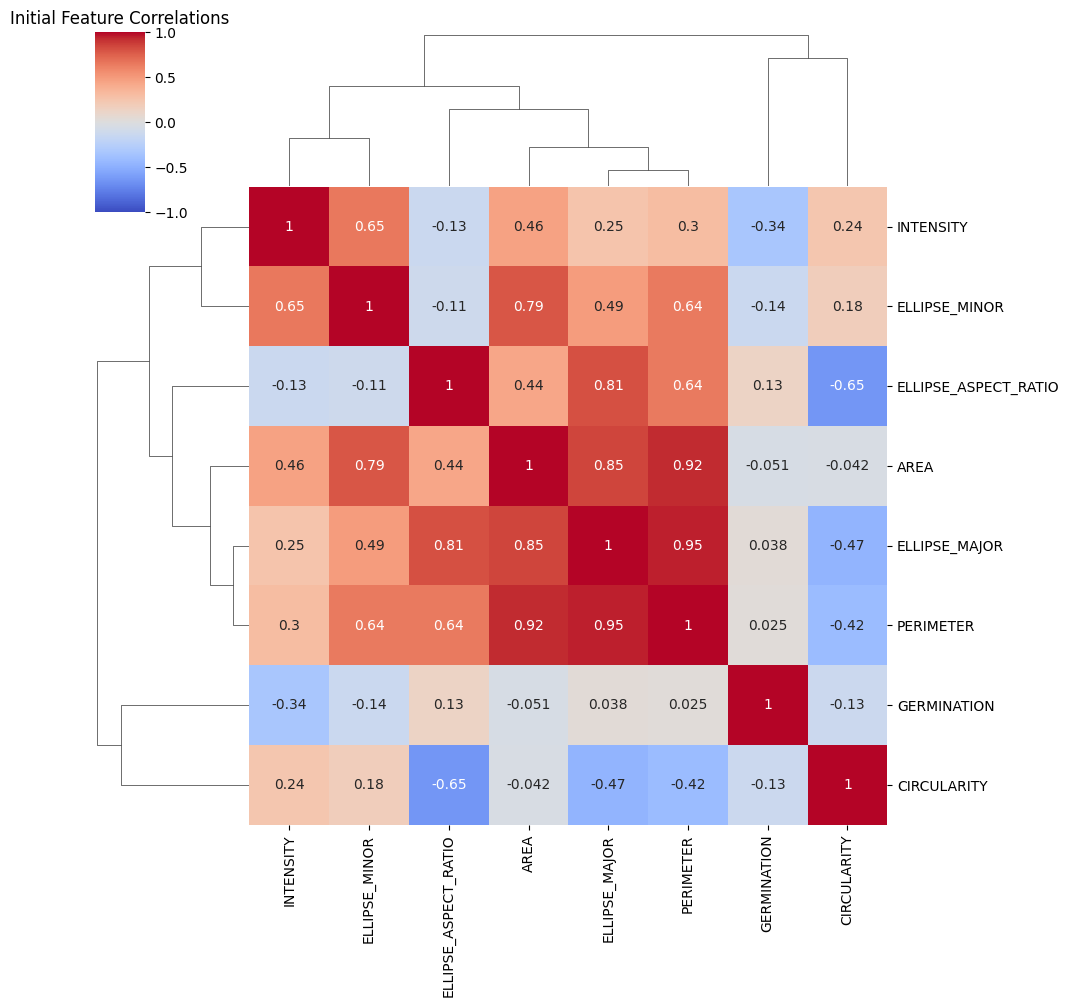

doing ANOVA and tukey analysis for GERMINATION...
ANOVA one-way results for GERMINATION:
F_onewayResult(statistic=28838.74109278553, pvalue=6.190975716574077e-82)
Tukey Analysis:
      Multiple Comparison of Means - Tukey HSD, FWER=0.05       
  group1     group2    meandiff p-adj   lower     upper   reject
----------------------------------------------------------------
   (0, 25) (100, 300)     168.2   0.0  166.4762  169.9238   True
   (0, 25)   (25, 50)   24.0462   0.0   23.2777   24.8146   True
   (0, 25)   (50, 75)   48.2556   0.0   47.4601    49.051   True
   (0, 25)  (75, 100)      72.2   0.0   71.1444   73.2556   True
(100, 300)   (25, 50) -144.1538   0.0 -145.7574 -142.5503   True
(100, 300)   (50, 75) -119.9444   0.0 -121.5612 -118.3277   True
(100, 300)  (75, 100)     -96.0   0.0  -97.7593  -94.2407   True
  (25, 50)   (50, 75)   24.2094   0.0   23.7269   24.6919   True
  (25, 50)  (75, 100)   48.1538   0.0   47.3087    48.999   True
  (50, 75)  (75, 100)   23.9444   0.0   2

<Figure size 800x600 with 0 Axes>

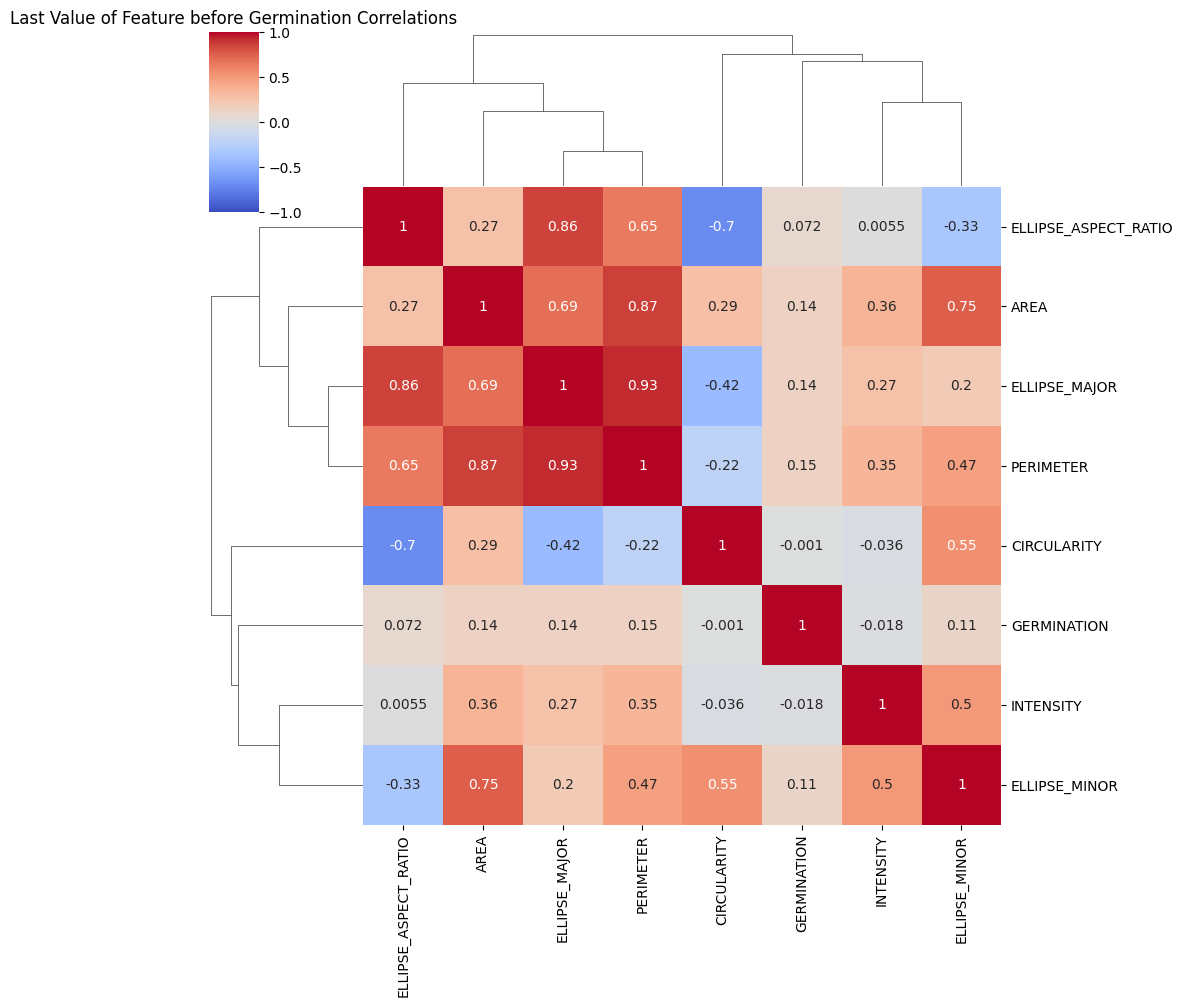

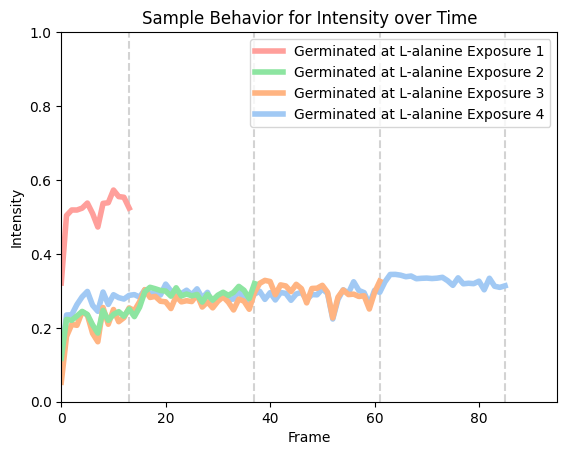

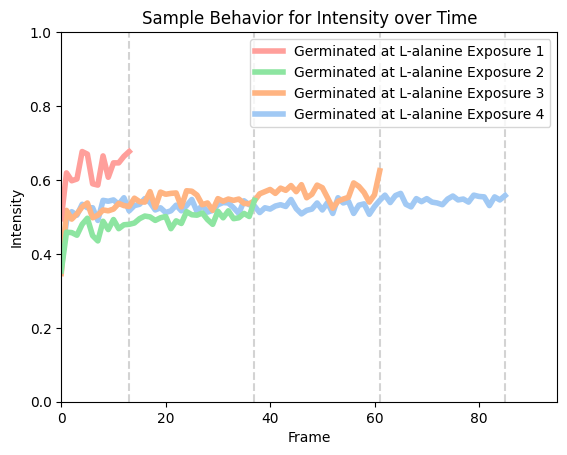

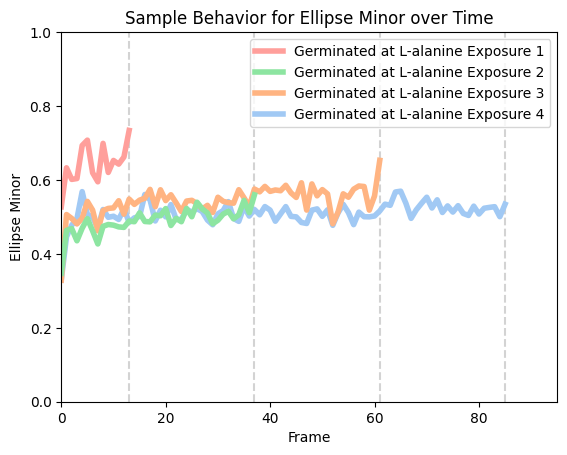

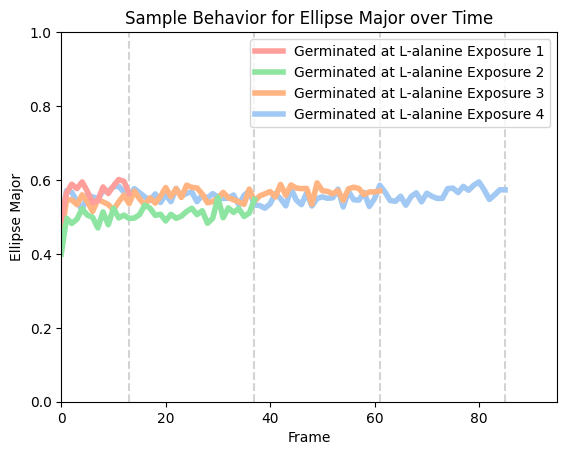

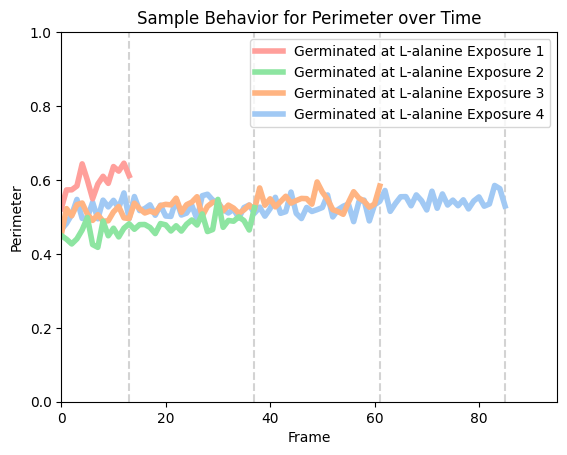

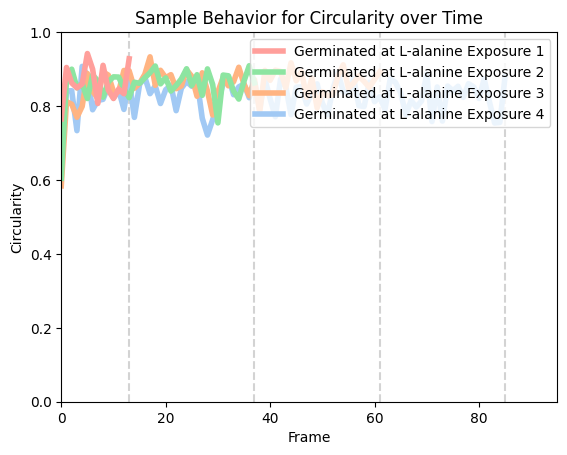

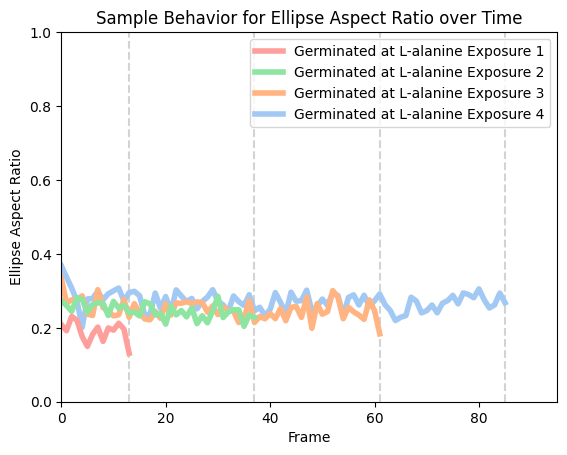

In [390]:
csv_path = "/Users/alexandranava/Desktop/Spores/M4581_s1/Analysis/V3/M4581_s1_Model_Data.csv"
plots_folder = "/Users/alexandranava/Desktop/Spores/M4581_s1/Analysis/V3/Plots/"
time_between_frames = 5

columns_to_scale = ['INTENSITY', 'AREA', 'GERMINANT EXPOSURE', 'GERMINATION',
                    'ELLIPSE MINOR', 'ELLIPSE MAJOR', 'PERIMETER', 'CIRCULARITY', "ELLIPSE ASPECT RATIO"]

M4581_s1_df  = scale_csv_data(csv_path, columns_to_scale)

#M4581_s1_df = pd.read_csv(csv_path)
Main(M4581_s1_df, plots_folder, time_between_frames)


### M4576_s2 Analysis

data has columns ['Unnamed: 0', 'INTENSITY', 'AREA', 'GERMINANT EXPOSURE', 'GERMINATION', 'ELLIPSE MINOR', 'ELLIPSE MAJOR', 'PERIMETER', 'CIRCULARITY', 'FRAME LIST', 'ELLIPSE ASPECT RATIO', 'X_POSITION', 'Y_POSITION']...
analyzing 76 spores...
Frame: 13, Frequency: 4
Frame: 14, Frequency: 1
Frame: 16, Frequency: 1
Frame: 37, Frequency: 19
Frame: 38, Frequency: 22
Frame: 39, Frequency: 1
Frame: 40, Frequency: 1
Frame: 57, Frequency: 3
Frame: 61, Frequency: 12
Frame: 62, Frequency: 9
Frame: 85, Frequency: 1
Frame: 86, Frequency: 2


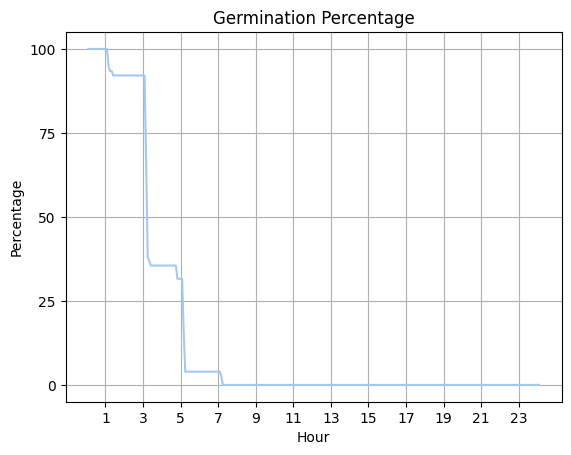

Percentages: [100, 94.73684210526315, 93.42105263157895, 92.10526315789474, 67.10526315789474, 38.15789473684211, 36.84210526315789, 35.526315789473685, 31.57894736842105, 15.789473684210526, 3.9473684210526314, 2.631578947368421, 0.0]


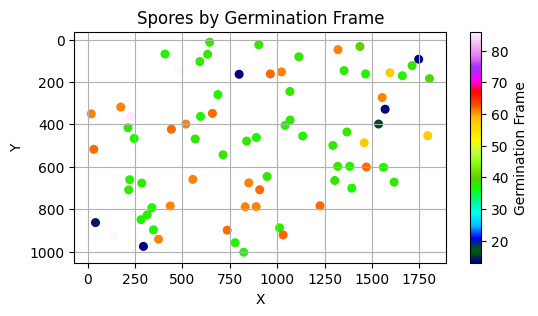

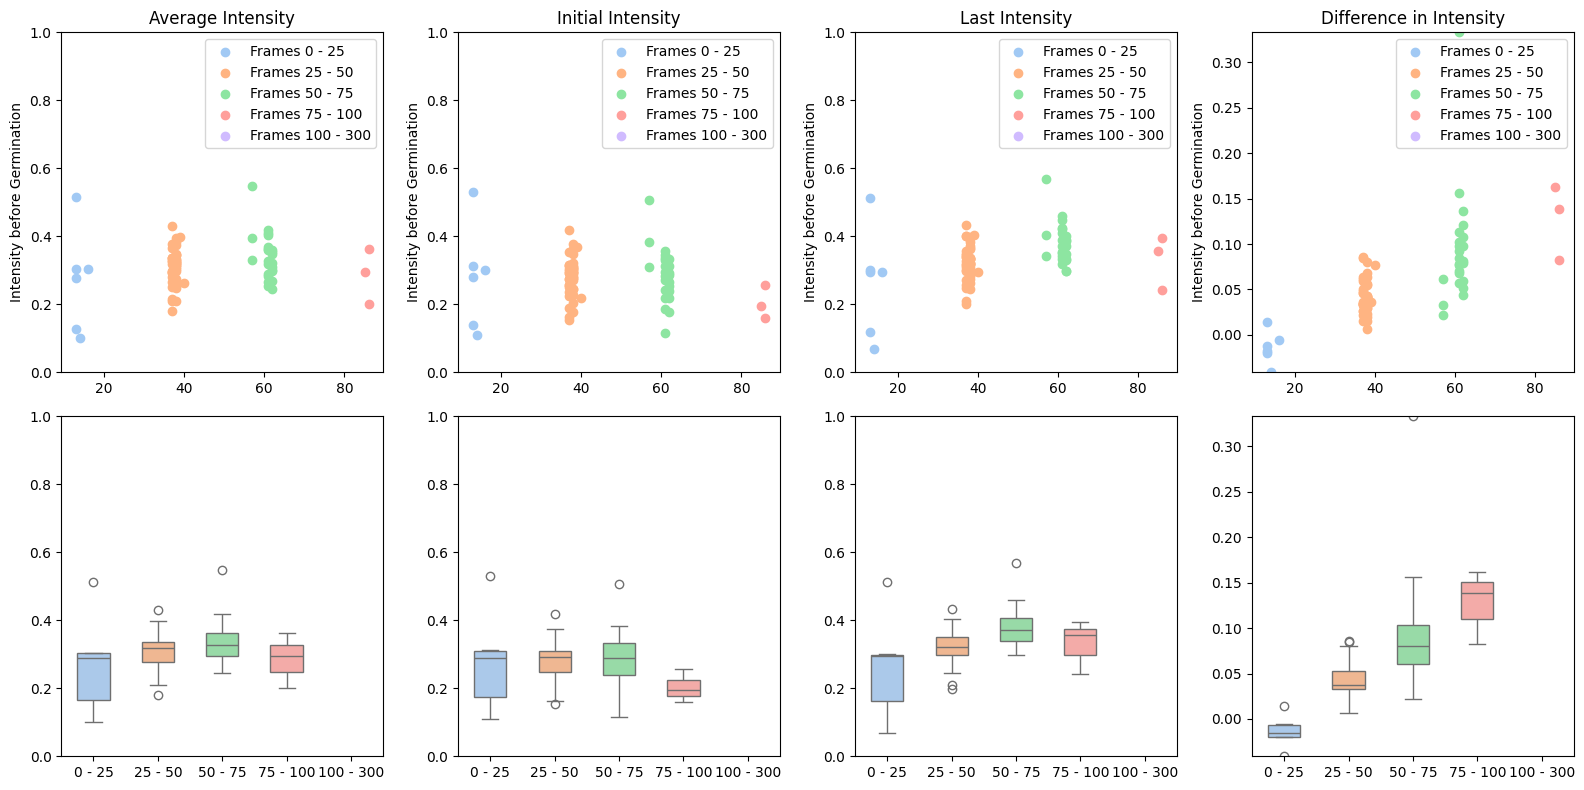

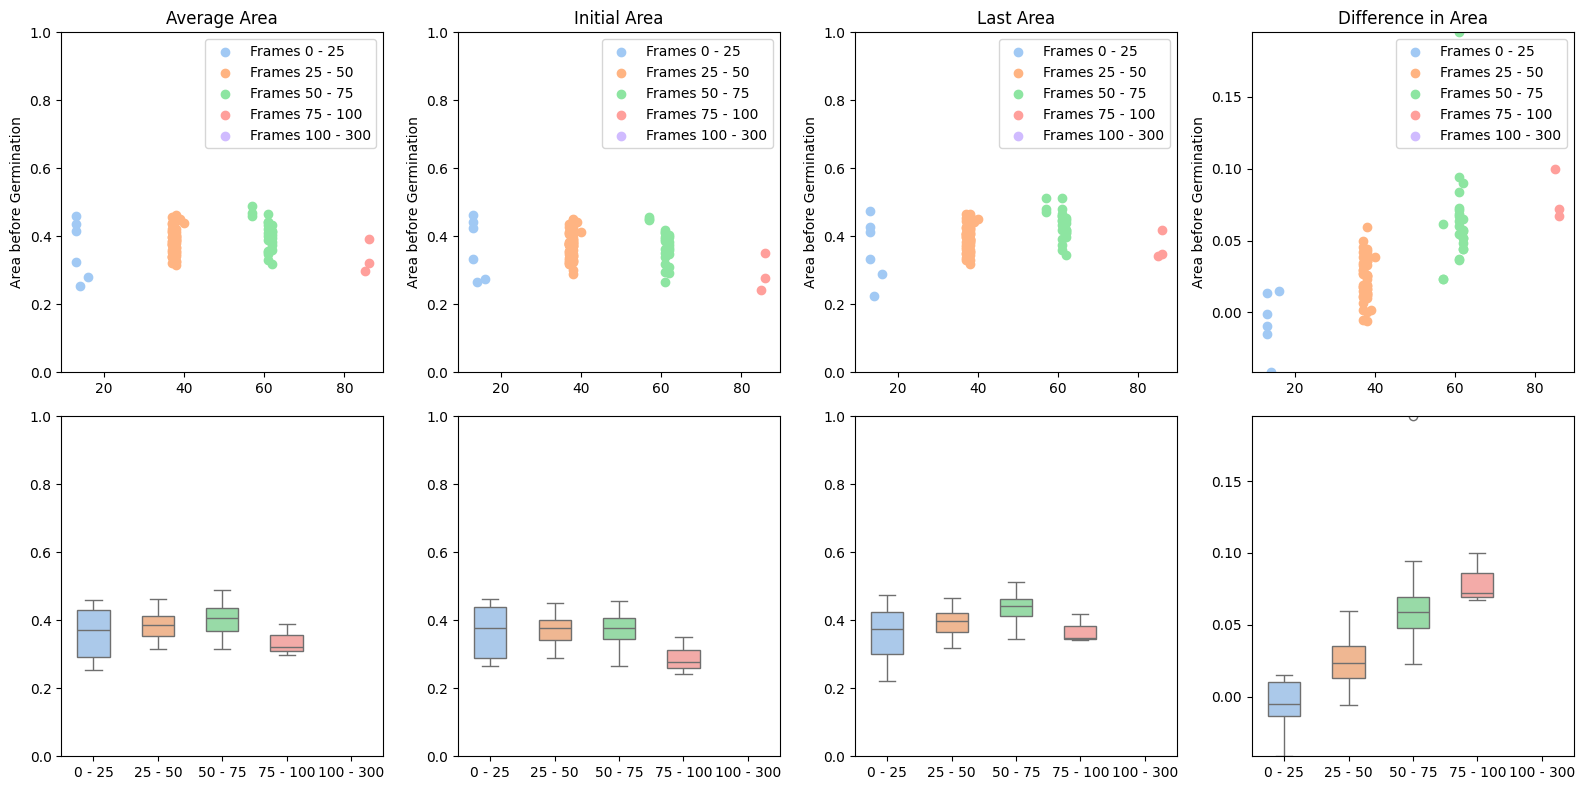

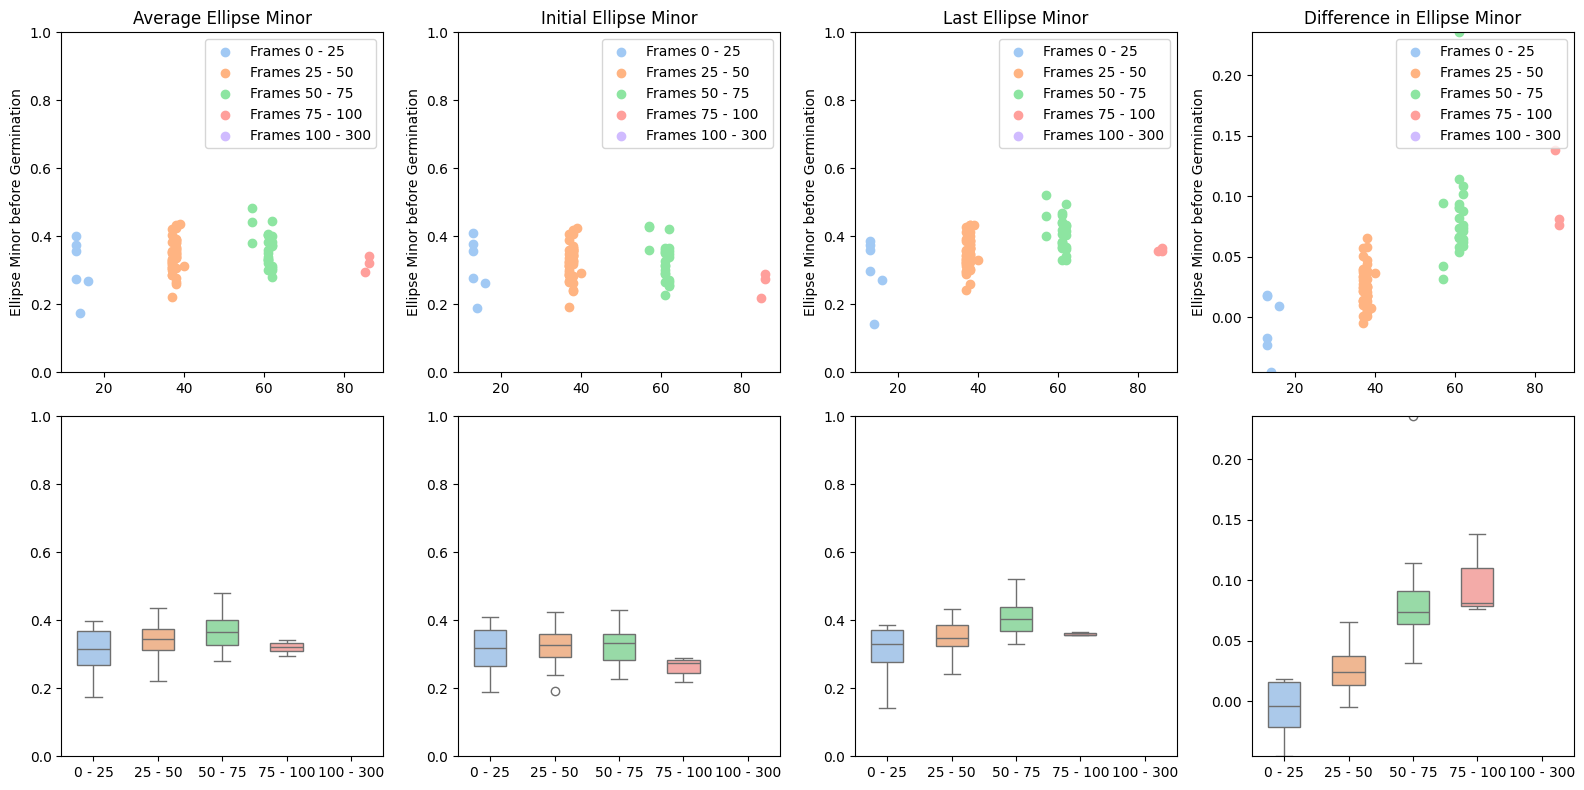

<Figure size 640x480 with 0 Axes>

<Figure size 800x600 with 0 Axes>

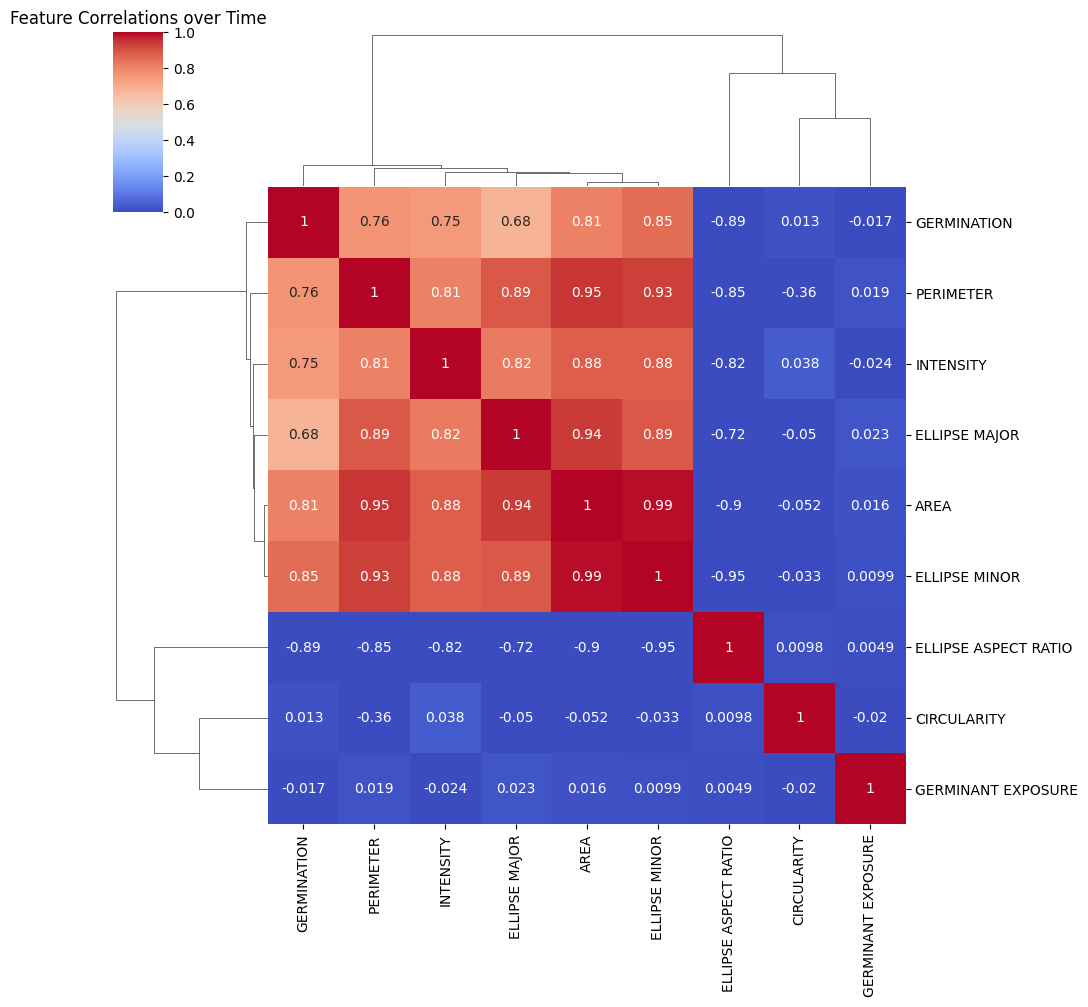

<Figure size 800x600 with 0 Axes>

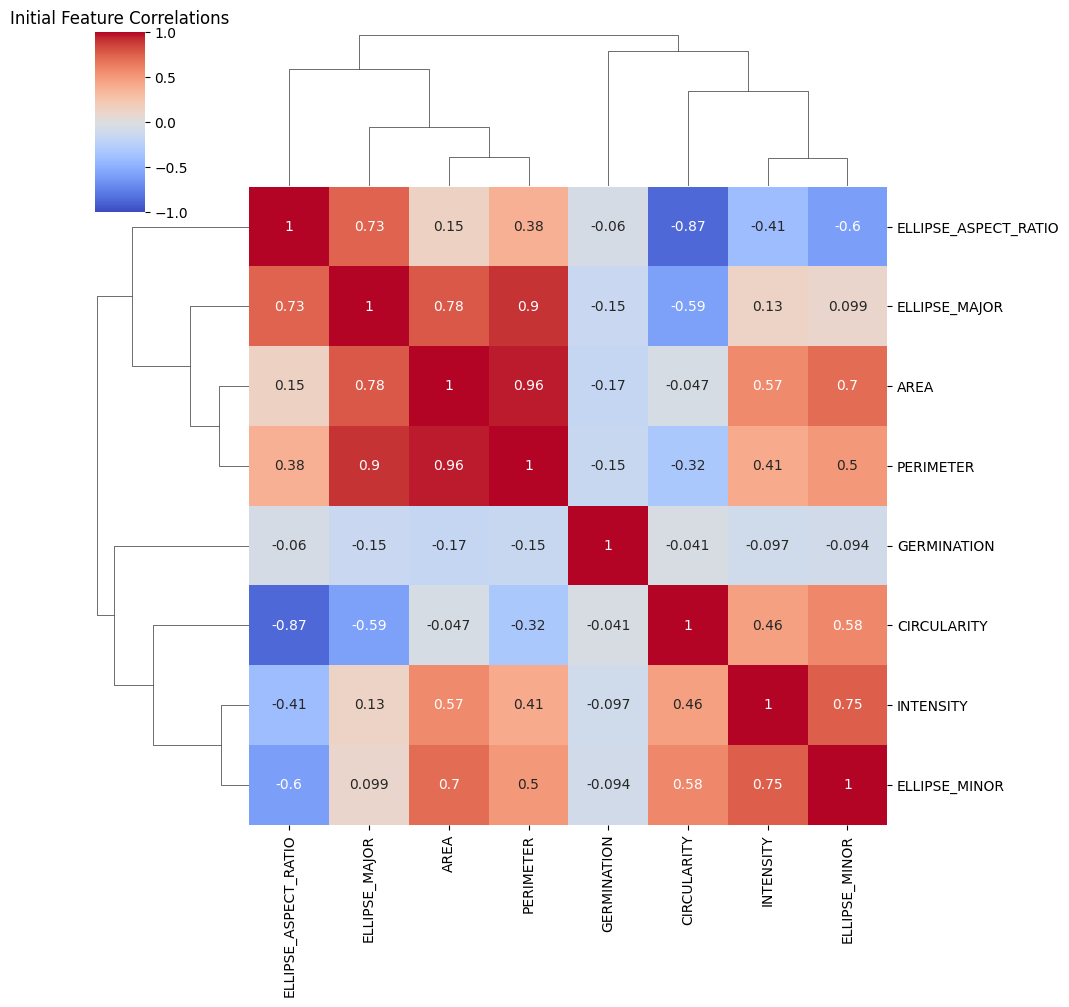

doing ANOVA and tukey analysis for GERMINATION...
ANOVA one-way results for GERMINATION:
F_onewayResult(statistic=nan, pvalue=nan)


/Users/alexandranava/Library/Python/3.9/lib/python/site-packages/scipy/stats/_stats_py.py:4133: DegenerateDataWarning: at least one input has length 0
  warnings.warn(stats.DegenerateDataWarning('at least one input '


Tukey Analysis:
  Multiple Comparison of Means - Tukey HSD, FWER=0.05   
 group1    group2  meandiff p-adj  lower   upper  reject
--------------------------------------------------------
 (0, 25)  (25, 50)  23.9612   0.0  22.733 25.1894   True
 (0, 25)  (50, 75)  47.2083   0.0  45.922 48.4947   True
 (0, 25) (75, 100)     72.0   0.0 70.0072 73.9928   True
(25, 50)  (50, 75)  23.2471   0.0  22.529 23.9652   True
(25, 50) (75, 100)  48.0388   0.0 46.3558 49.7217   True
(50, 75) (75, 100)  24.7917   0.0 23.0659 26.5175   True
--------------------------------------------------------
doing ANOVA and tukey analysis for INTENSITY...
ANOVA one-way results for INTENSITY:
F_onewayResult(statistic=nan, pvalue=nan)
Tukey Analysis:
  Multiple Comparison of Means - Tukey HSD, FWER=0.05   
 group1    group2  meandiff p-adj   lower  upper  reject
--------------------------------------------------------
 (0, 25)  (25, 50)   0.0027 0.9998 -0.0822 0.0876  False
 (0, 25)  (50, 75)   0.0075 0.9962 -0.0814 

<Figure size 800x600 with 0 Axes>

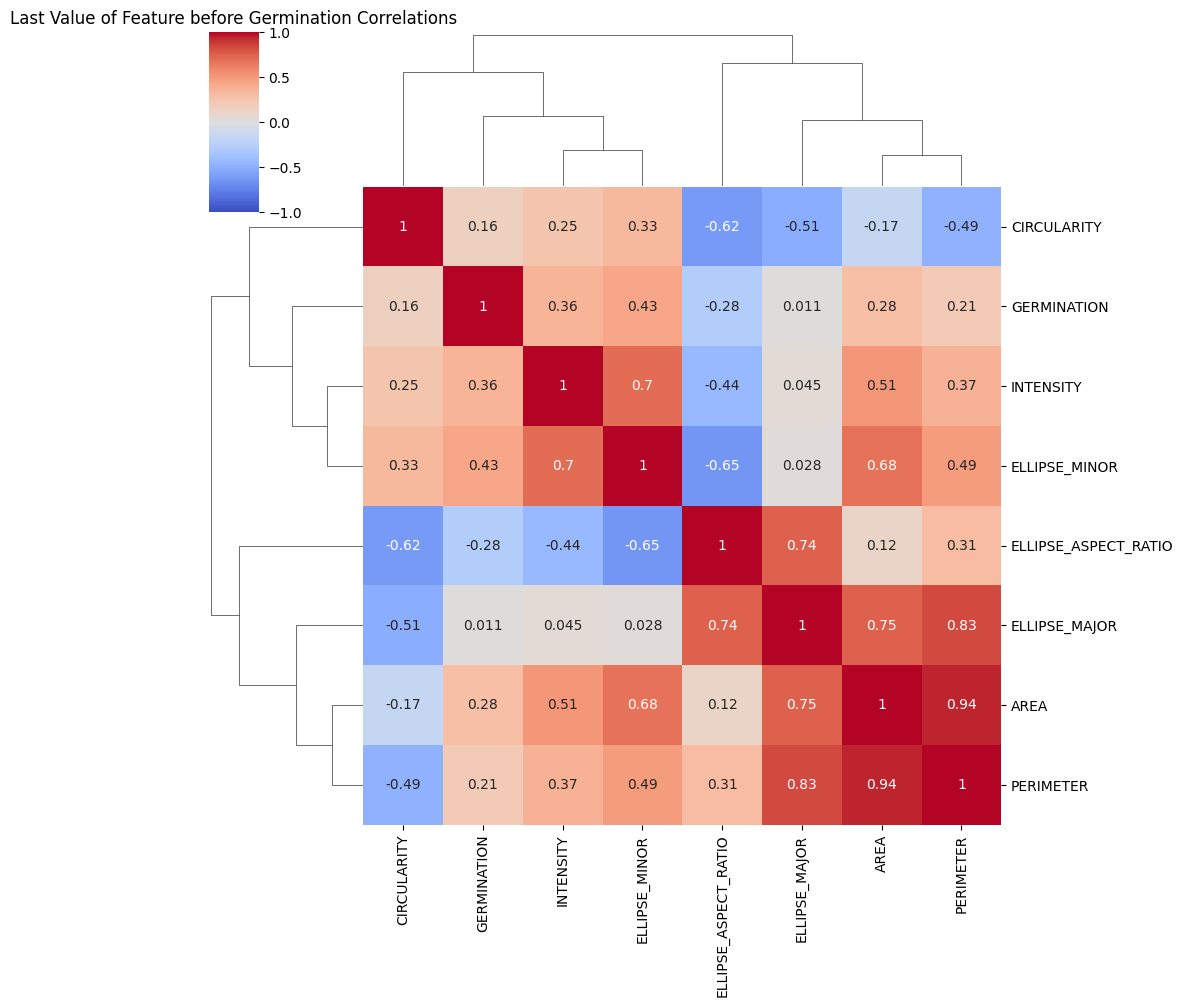

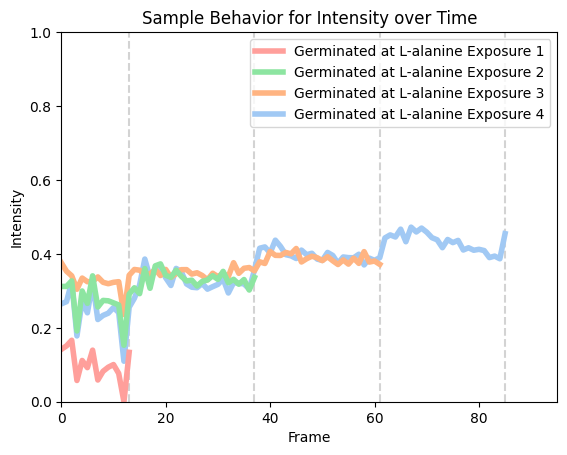

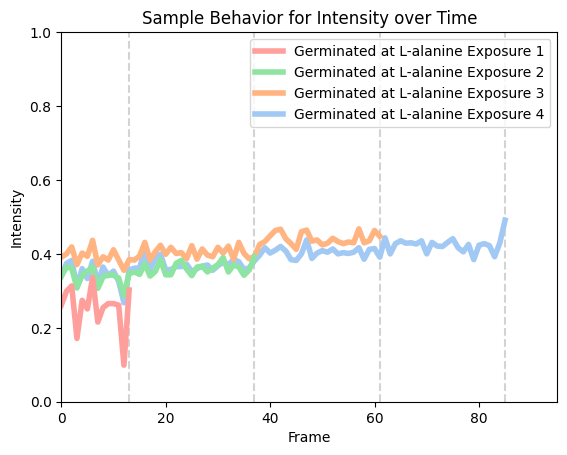

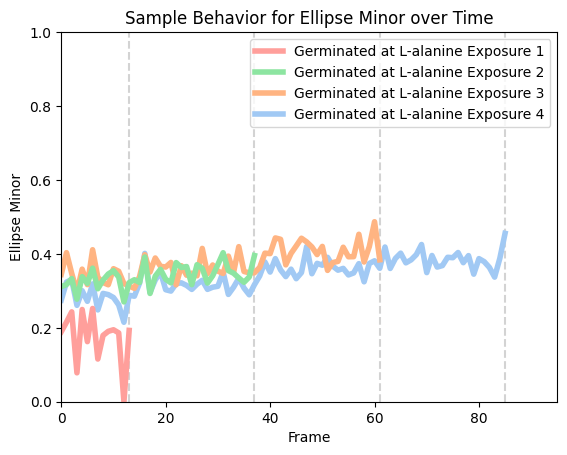

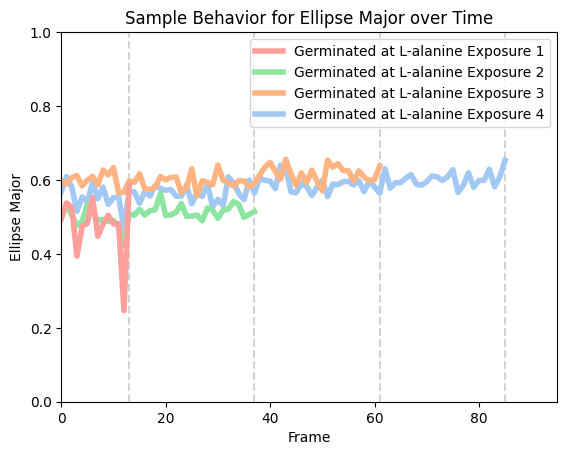

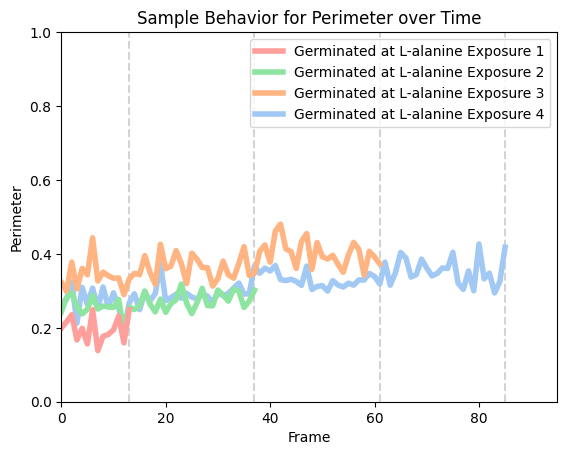

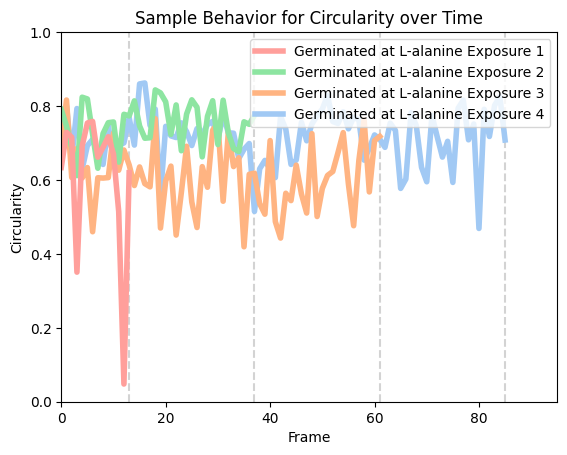

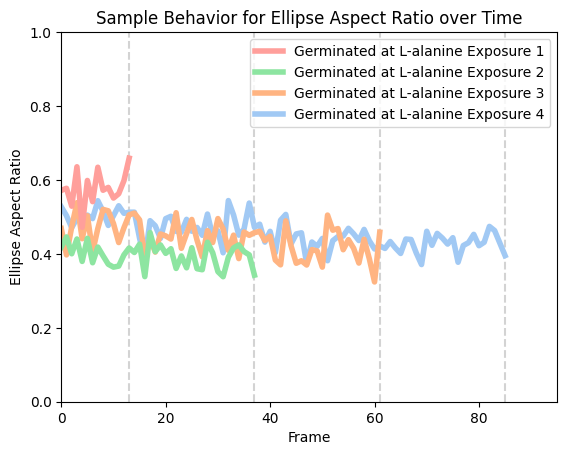

In [391]:
csv_path2 = "/Users/alexandranava/Desktop/Spores/M4576_s2/M4576_s2_Model_Data.csv"
plots_folder2 = "/Users/alexandranava/Desktop/Spores/M4576_s2/Analysis/Plots/"
time_between_frames2 = 5

columns_to_scale = ['INTENSITY', 'AREA', 'GERMINANT EXPOSURE', 'GERMINATION',
                    'ELLIPSE MINOR', 'ELLIPSE MAJOR', 'PERIMETER', 'CIRCULARITY', "ELLIPSE ASPECT RATIO"]

M4576_s2_df  = scale_csv_data(csv_path2, columns_to_scale)

#M4567_s2_df = pd.read_csv(csv_path2)
Main(M4576_s2_df, plots_folder2, time_between_frames2)

### Both datasets: 

data has columns ['Unnamed: 0', 'INTENSITY', 'AREA', 'GERMINANT EXPOSURE', 'GERMINATION', 'ELLIPSE MINOR', 'ELLIPSE MAJOR', 'PERIMETER', 'CIRCULARITY', 'FRAME LIST', 'ELLIPSE ASPECT RATIO', 'X_POSITION', 'Y_POSITION']...
analyzing 130 spores...
Frame: 13, Frequency: 5
Frame: 14, Frequency: 5
Frame: 16, Frequency: 1
Frame: 37, Frequency: 24
Frame: 38, Frequency: 42
Frame: 39, Frequency: 2
Frame: 40, Frequency: 1
Frame: 57, Frequency: 3
Frame: 61, Frequency: 15
Frame: 62, Frequency: 21
Frame: 63, Frequency: 2
Frame: 64, Frequency: 1
Frame: 85, Frequency: 1
Frame: 86, Frequency: 6
Frame: 182, Frequency: 1


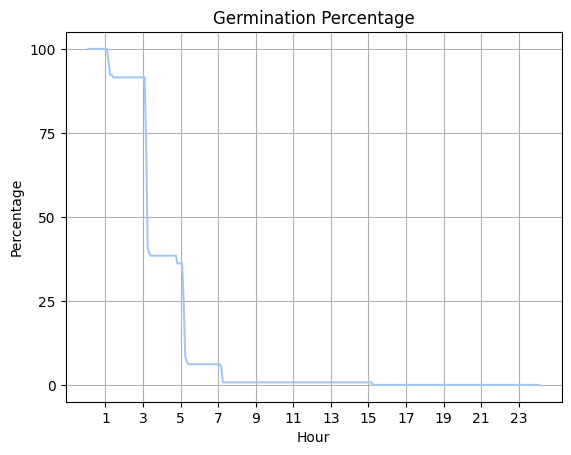

Percentages: [100, 96.15384615384616, 92.3076923076923, 91.53846153846153, 73.07692307692307, 40.76923076923077, 39.23076923076923, 38.46153846153847, 36.15384615384615, 24.615384615384617, 8.461538461538462, 6.923076923076923, 6.153846153846154, 5.384615384615385, 0.7692307692307693, 0.0]


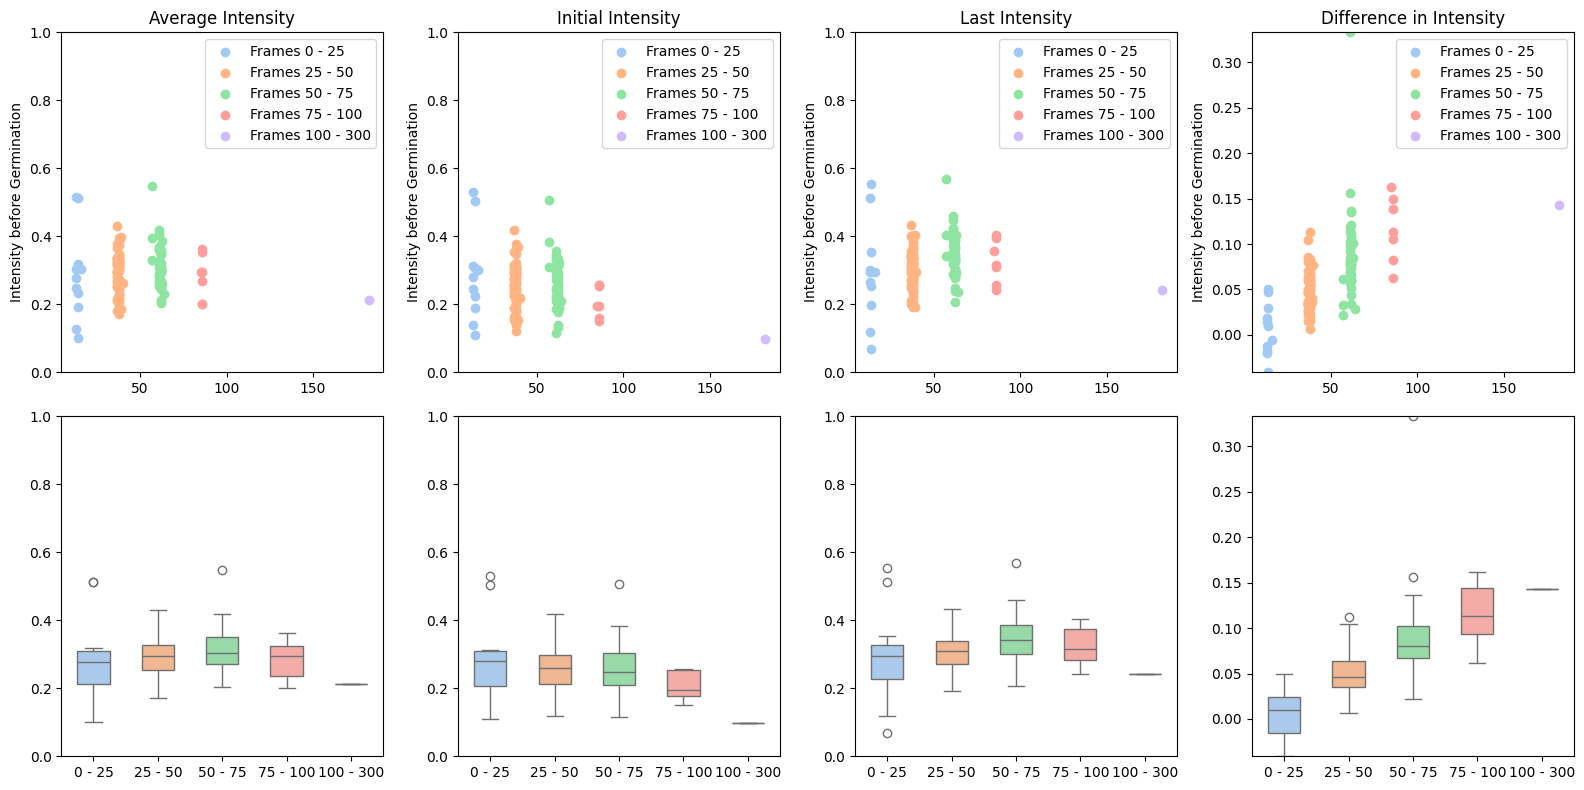

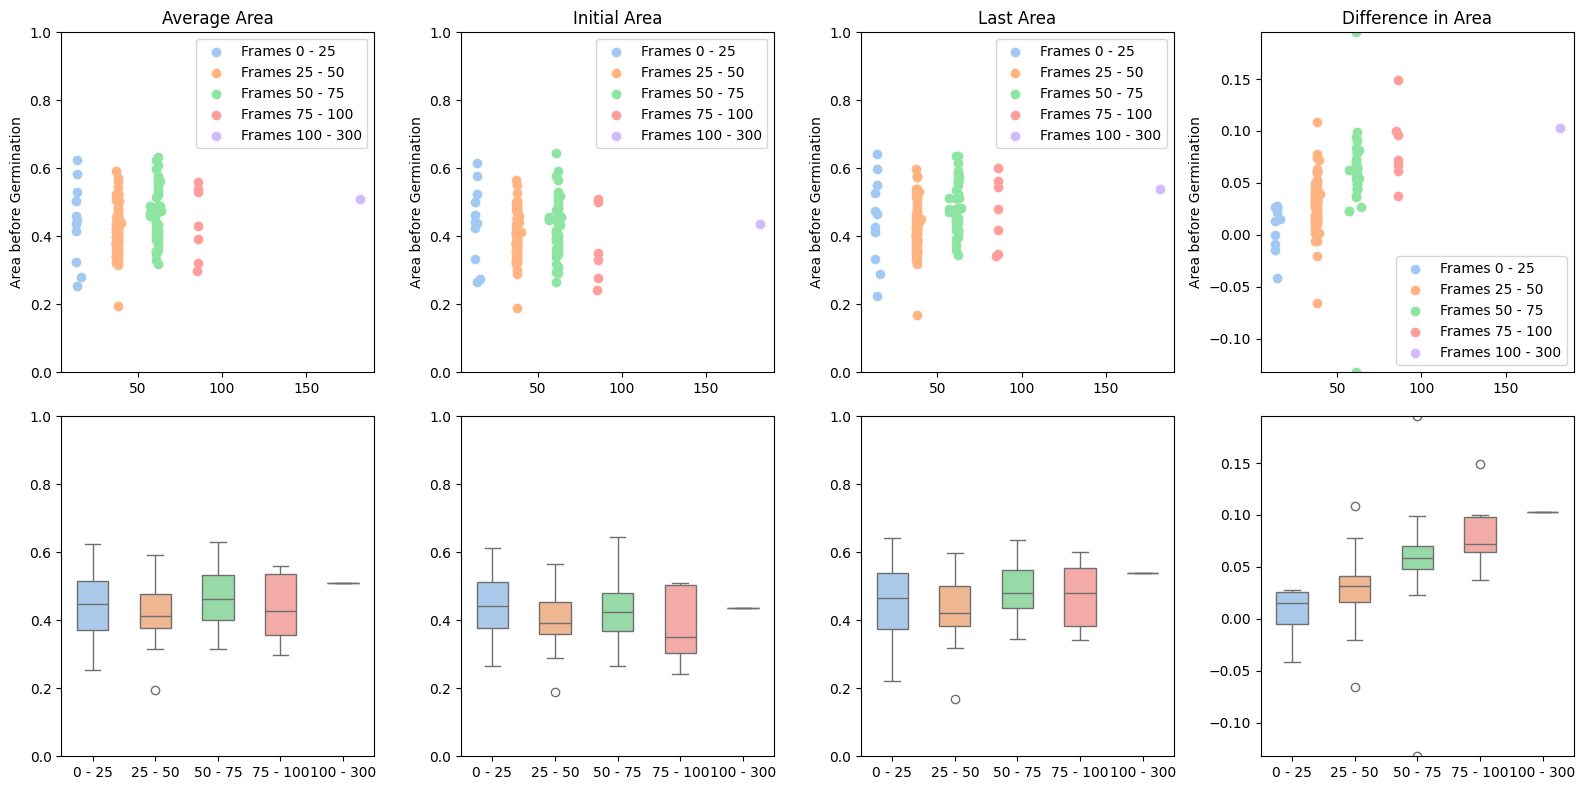

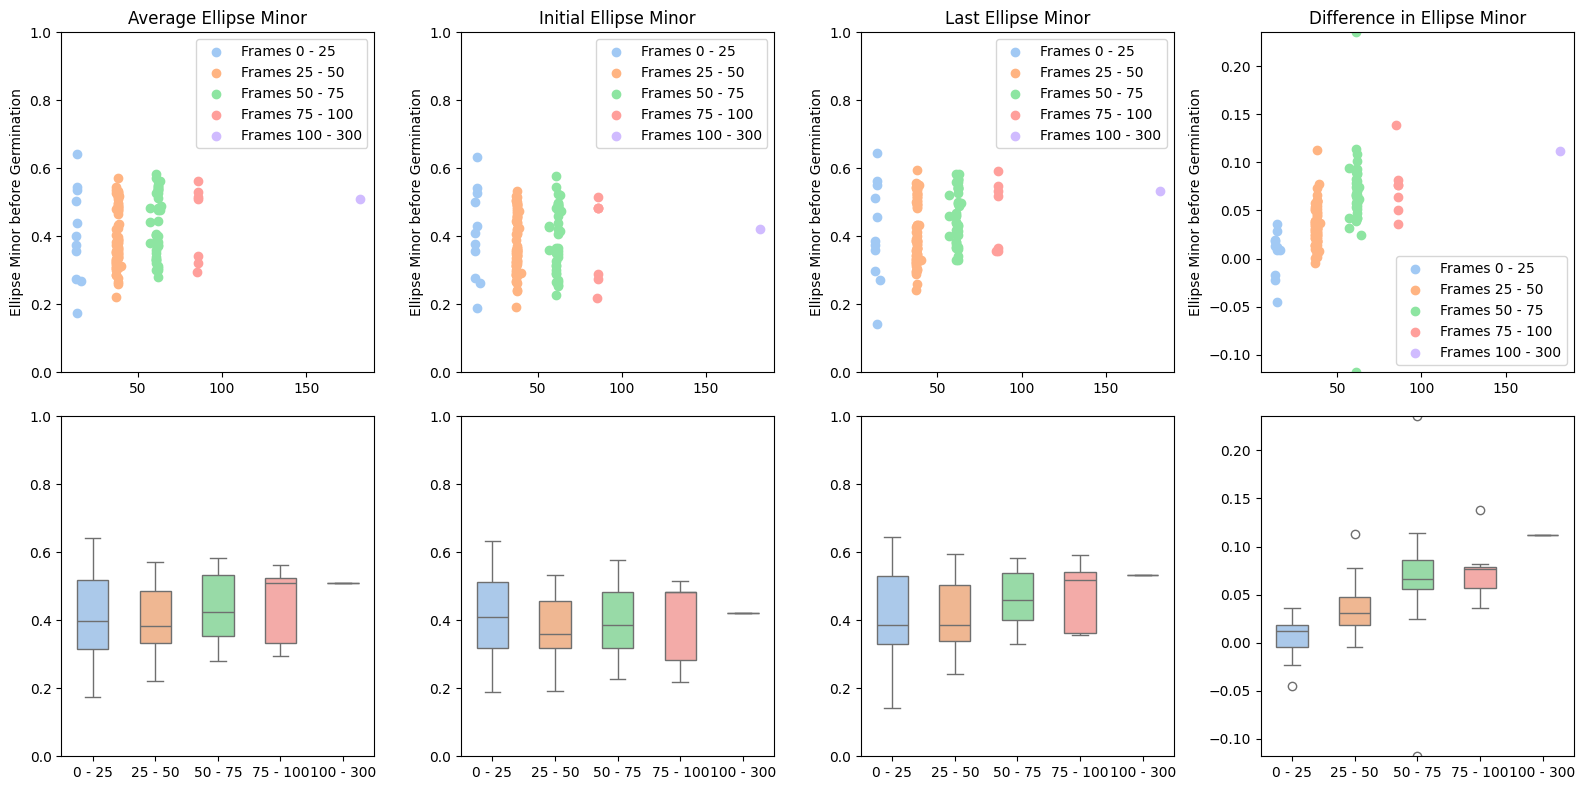

<Figure size 640x480 with 0 Axes>

<Figure size 800x600 with 0 Axes>

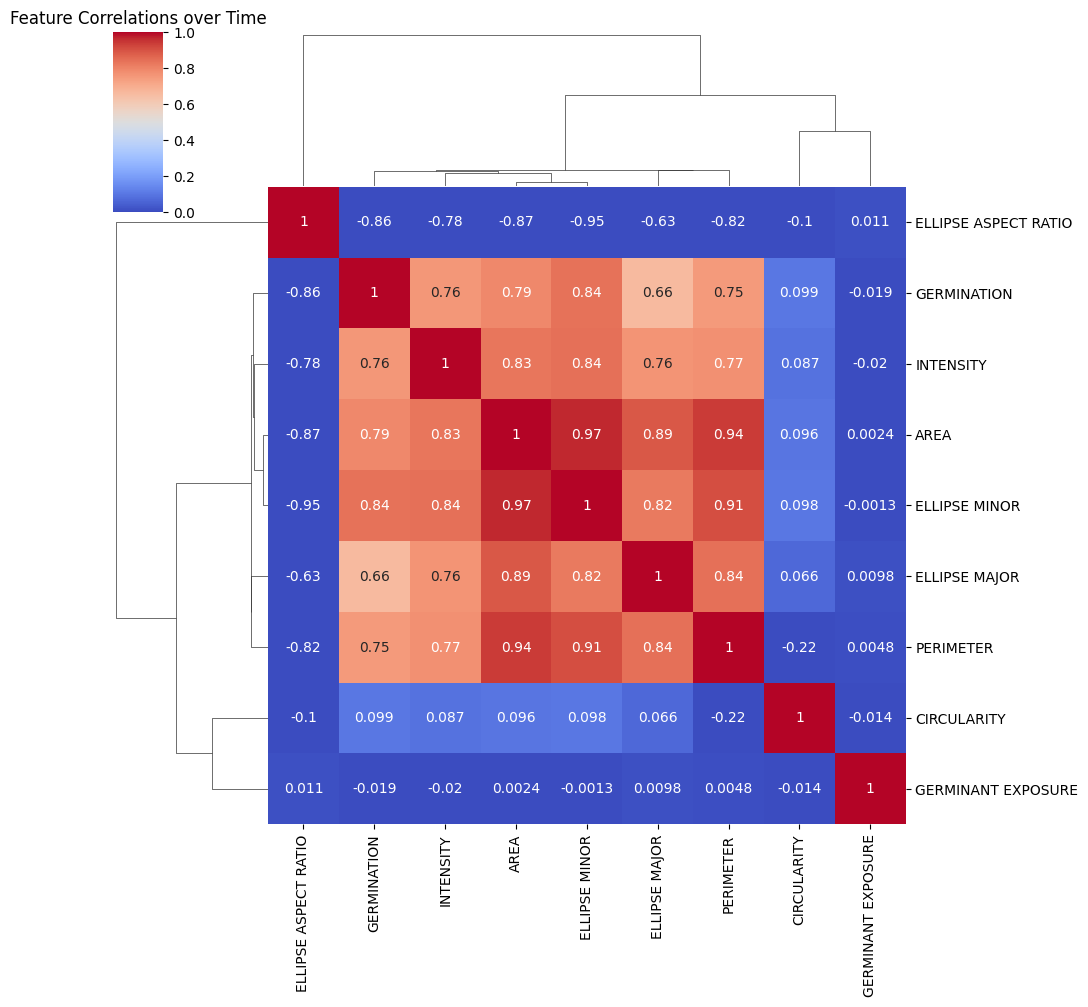

<Figure size 800x600 with 0 Axes>

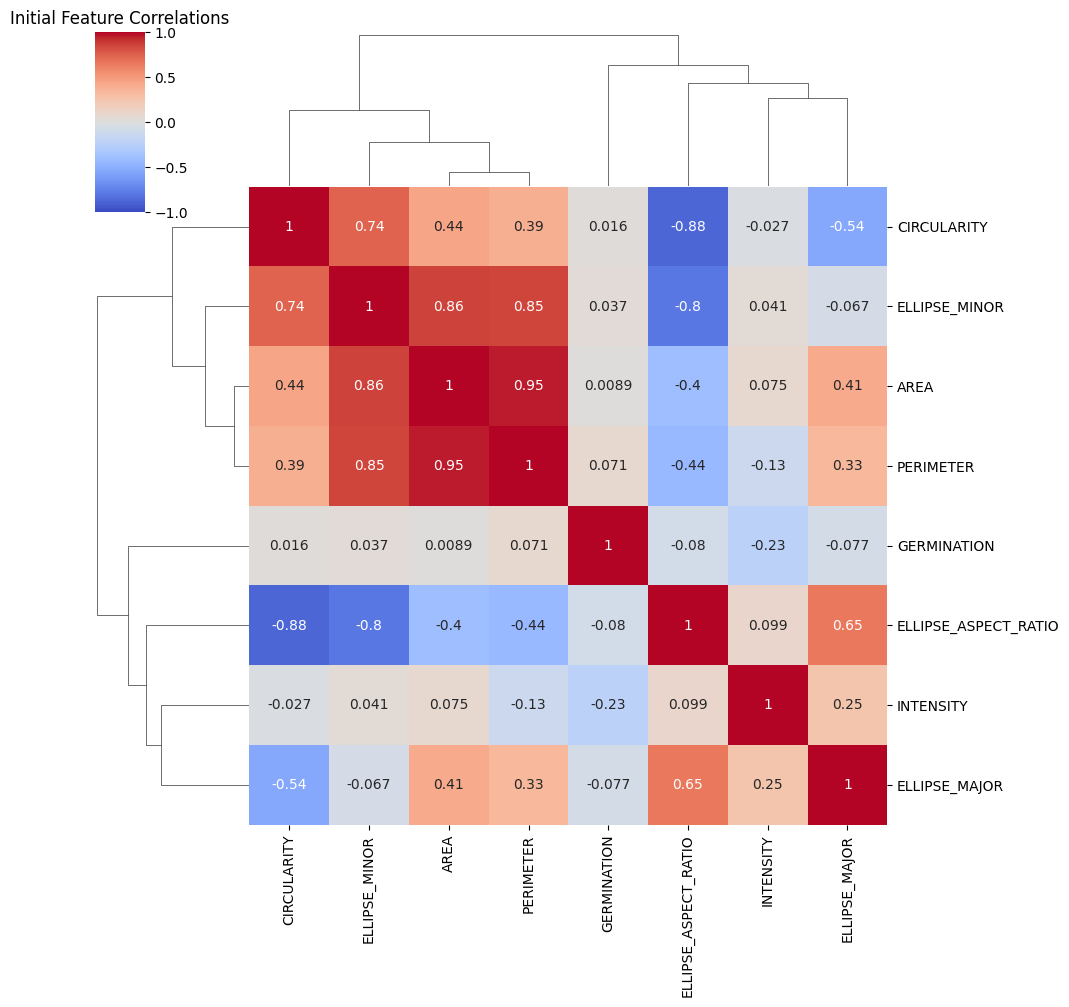

doing ANOVA and tukey analysis for GERMINATION...
ANOVA one-way results for GERMINATION:
F_onewayResult(statistic=15359.696992894003, pvalue=3.356969515491729e-167)
Tukey Analysis:
      Multiple Comparison of Means - Tukey HSD, FWER=0.05       
  group1     group2    meandiff p-adj   lower     upper   reject
----------------------------------------------------------------
   (0, 25) (100, 300)  168.2727   0.0  165.5221  171.0233   True
   (0, 25)   (25, 50)   23.9829   0.0   23.1279   24.8379   True
   (0, 25)   (50, 75)   47.6537   0.0   46.7617   48.5456   True
   (0, 25)  (75, 100)   72.1299   0.0   70.8566   73.4031   True
(100, 300)   (25, 50) -144.2899   0.0 -146.9424 -141.6373   True
(100, 300)   (50, 75)  -120.619   0.0 -123.2837 -117.9544   True
(100, 300)  (75, 100)  -96.1429   0.0  -98.9582  -93.3275   True
  (25, 50)   (50, 75)   23.6708   0.0   23.1554   24.1862   True
  (25, 50)  (75, 100)    48.147   0.0   47.1024   49.1916   True
  (50, 75)  (75, 100)   24.4762   0.0  

In [392]:
plots_folder_combined = "/Users/alexandranava/Desktop/Spores/M4581_s1andM4576_s2/plots/"

columns_to_scale = ['INTENSITY', 'AREA', 'GERMINANT EXPOSURE', 'GERMINATION',
                    'ELLIPSE MINOR', 'ELLIPSE MAJOR', 'PERIMETER', 'CIRCULARITY', "ELLIPSE ASPECT RATIO"]

M4581_s1_scaleddf  = scale_csv_data(csv_path, columns_to_scale)
M4567_s2_scaleddf = scale_csv_data(csv_path2, columns_to_scale)

df_stacked = pd.concat([M4581_s1_scaleddf, M4567_s2_scaleddf], axis=0)
df_stacked.reset_index(drop=True, inplace=True)

Main(df_stacked, plots_folder_combined, 5, combined_df = 1)